In [1]:
struct Global
    nv          ::Int    #boundary point
    jx          ::Int    #cell number
    #nm          ::Int    #N of matter
    kindProblem ::Int #kind of problem
    tt          ::Float64      #total time
    cfl         ::Float64     # cfl
end

struct Const
    Y0 ::Float64
    ρ0 ::Float64
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end
    

struct Var
    ρ ::Float64
    u ::Float64
    p ::Float64
    sxx::Float64
end


$$ 1Pa = 1N/m^2 = 1 kg/(m\cdot s^2) = 10^{-11} g/(cm \cdot \mu s^2)$$ 

$$ 1 m/s = 10^{-4} cm/\mu s$$
$$ 1kg/m^3 = 10^{-3} g/cm^3$$


$$f(\eta) = \frac{(\eta-1)(\eta-\Gamma_0(\eta-1)/2)}{(\eta-s_0(\eta-1))^2}$$
$$f'(\eta) = \frac{\eta+(s_0-\Gamma_0)(\eta-1)}{(\eta-s_0(\eta-1))^3}$$

In [2]:

function fη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fη=(η-1.0)*(η-c.Γ0*(η-1.0)/2.0)/(η-c.s0*(η-1))^2
end

function fηη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fηη=(η+(c.s0-c.Γ0)*(η-1))/(η-c.s0*(η-1))^3
end


fηη (generic function with 1 method)

Mie-Gr\"uneisen equation of state
$$e =\frac{p-\rho_0a_0^2f(\eta)}{\rho_0\Gamma_0}$$

$$p = \rho_0a_0^2f(\eta)+\rho_0\Gamma_0e$$

In [3]:
function PToe(ρ::Float64,p::Float64,con::Const)
    c=con
    ei = (p-c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function EToP(ρ::Float64,ei::Float64,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei+c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

EToP (generic function with 1 method)

$$ \begin{aligned}
    & \rho = uo[1]\\
    & u  = uo[2]\\
    & p =uo[3]\\
    & s_{xx}=uo[4]
     \end{aligned} \hspace{0.3cm}
    \begin{aligned}
    &U[1]=\rho\\
    &U[2]=\rho u\\
    &U[3]=\rho E\\
    &U[4]=s_{xx}\\
    \end{aligned}
$$

$$ e=E/\rho-\frac{1}{2}u^2$$


In [4]:
"""
 from  the primitive variables uo to  conservative variables U
"""
function UoTou(uo::Array{Float64,1},con::Const)
    u = zeros(Float64, 4)
    u[1]=uo[1]
    u[2]=uo[2]*uo[1]
    ei = PToe(uo[1],uo[3],con)
    u[3]=(ei+0.5uo[2]^2)*uo[1]
    u[4]=uo[4]
    return u
end

UoTou

In [5]:
"""
 from conservative variables U  to  the primitive variables uo
"""
function UToUo(u::Array{Float64,1},con::Const)
    uo = zeros(Float64, 4)
    uo[1]=u[1]
    uo[2]=u[2]/u[1]
    ei=u[3]/uo[1]-0.5uo[2]^2
    p = EToP(uo[1],ei,con)
    uo[3]=p
    uo[4]=u[4]
    return uo
end  

UToUo

$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}+\frac{4}{3}\frac{\mu}{\rho}}$$
$$ a^2= a_0^2 f'(\eta)+\frac{p}{\rho^2}\rho_0\Gamma_0$$

In [6]:
function sound(uo::Array{Float64,1},con::Const)
    a0  = con.a0
    ρ0  = con.ρ0
    Γ0  = con.Γ0
    μ   = con.μ
    ρ   = uo[1]
    uu  = uo[2]
    p   = uo[3]
    sxx = uo[4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
  #  c = ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,fηη(ρ,con),p)
    
    c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
    
    return c
end




sound (generic function with 1 method)

In [7]:
# ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,f,p)=try
#         sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
#     catch
#         println("a2= ",a2,"ρ0 = ", ρ0,"ρ = ",
#             ρ, "Γ0= ",Γ0,"Sxx = ", sxx,μ, "a0 = ", 
#             a0, "f = ",f, "p = ", p)
#     end



In [8]:
function Cfl(uo::Array{Float64,2},x::Array{Float64,1},
        inter::Array{Int,1},problem::Global=problem )
    nv=problem.nv
    jx=problem.jx
    sf=problem.cfl
    
   dx1=0
   dxmin=x[nv+2]-x[nv+1]
    for i in nv+2:jx+nv+1
        dx  = x[i]-x[i-1]
        if inter[i] == 1
            c = sound(uo[i,:],con1)
        else
            c = sound(uo[i,:],con2)
        end
        dxmin = min(dx,dxmin)
        dx1=dxmin/c
    end
   dt=sf*dx1
   return dt
end    

Cfl (generic function with 2 methods)

In [9]:
function WENO3(u::Array{Float64,1})
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        IS0 = (u[i] - u[i-1])^2
        IS1 = (u[i+1] - u[i])^2
        
        c0 = 2/3
        c1 = 1/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
        
        c0 = 1/3
        c1 = 2/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
    end
    return uL,uR
end

function WENO3(u::Array{Float64,1},inter::Array{Int,1},ik::Int)
    
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    
    for i in 2:I-1
        
        if inter[i] != inter[i+1] #&& (ik == 4 || ik == 3) 
                
            IS0 = (u[i] - u[i-1])^2
            IS1 = 0  #(u[i+1] - u[i])^2

            c0 = 2/3
            c1 = 1/3

            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)

            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
             uR[i-1] = β0*(u[i]+u[i-1])/2+β1*u[i]
             uR[i-1] = u[i]

            c0 = 1/3
            c1 = 2/3

            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)

            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
             uL[i] = β0*(3u[i]-u[i-1])/2+β1*u[i]
               uL[i] = u[i]
        elseif inter[i] != inter[i-1] #&& (ik == 4 || ik ==3)
            IS0 = 0 # (u[i] - u[i-1])^2
            IS1 = (u[i+1] - u[i])^2
        
            c0 = 2/3
            c1 = 1/3
        
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uR[i-1] = β0*u[i]+β1*(3u[i]-u[i+1])/2
            
            c0 = 1/3
            c1 = 2/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uL[i] = β0*u[i]+β1*(u[i]+u[i+1])/2
          ##  uR[i-1] = u[i]
          #  uL[i] =u[i]
         else
            IS0 = (u[i] - u[i-1])^2
            IS1 = (u[i+1] - u[i])^2
            
            c0 = 2/3
            c1 = 1/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
            
            c0 = 1/3
            c1 = 2/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
        end
    end
    return uL,uR
end

WENO3 (generic function with 2 methods)

In [10]:
function Upwind(u::Array{Float64,1})
     I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        uL[i] = u[i]
        uR[i] = u[i+1]
    end
    return uL,uR
end


Upwind (generic function with 1 method)

In [11]:
function Yυ(s::Float64,con::Const=con)
    Y0 = con.Y0
    f=0
    if abs(s) <= 2Y0/3
        f = s
    elseif s > 2Y0/3
        f = 2Y0/3
    else
        f = -2Y0/3
    end
end

Yυ (generic function with 2 methods)

$$s^* = \frac{\sigma_L -\sigma_R+\rho_L u_L(s_L-u_L)}$$

In [12]:
function HLLCEPNew1(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    ue = zeros(Float64,J)
    
    for  i in 1:I
           if inter[i] == 1 
            conL = con1
            conR = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ

            Y0R = con1.Y0
            ρ0R = con1.ρ0
            Γ0R = con1.Γ0
            a0R = con1.a0
            μR  = con1.μ
        else
            conL = con2
            conR = con2
            Y0L = con2.Y0
            ρ0L = con2.ρ0
            Γ0L = con2.Γ0
            a0L = con2.a0
            μL  = con2.μ

            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
             
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ
            
            conR = con2
            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
       end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4.0μL/3*log(ρLstar/ρL) +sxxL
        if (abs(sxxL) < 2Y0L/3 && abs(tmp) >= 2Y0L/3)

       # if abs(tmp) >= 2Y0/3 
            if tmp > 2Y0L/3
                hsxxL = 2Y0L/3
                hρL  = ρL*exp(-Y0L/(2μL)+3sxxL/(4μL))
            elseif tmp < -2/3*Y0L
                hsxxL = -2Y0L/3
                hρL  = ρL*exp(Y0L/(2μL)+3sxxL/(4μL))
            end
            t    = 1/ρL-1/hρL
            c0   = 1/(ρ0L*Γ0L)
            c1   = a0L^2/Γ0L
            hpL   = (2(c1*fη(hρL,conL)+eL)-t*(σL+hsxxL))/(2c0-t)
            hσL = -hpL + hsxxL
            if ρLstar > ρL
               huuL = uuL -sqrt((σL-hσL)*t)
            else
               huuL = uuL +sqrt((σL-hσL)*t)
            end
            ρL   = hρL
            uuL  = huuL
            pL   = hpL
            sxxL = hsxxL
            σL   = hσL
            ue[1] = ρL
            ue[2] = uuL
            ue[3] = pL
            ue[4] = sxxL
            cL = sound(ue,conL)
        end
        
        tmp = -4.0μR/3*log(ρRstar/ρR) +sxxR
        if abs(sxxR) < 2Y0R/3 && abs(tmp) >= 2Y0R/3 
        #if abs(tmp) >= 2Y0/3
            if tmp > 2Y0R/3
               hsxxR = 2Y0R/3
               hρR  = ρR*exp(-Y0R/(2μR)+3sxxR/(4μR))
            elseif tmp < -2/3*Y0R
               hsxxR = -2Y0R/3
               hρR  = ρR*exp(Y0R/(2μR)+3sxxR/(4μR))
            end
            t    = 1/ρR-1/hρR
            c0   = 1/(ρ0R*Γ0R)
            c1   = a0R^2/Γ0R
           hpR   = (2(c1*fη(hρR,conR)+eR)-t*(σR+hsxxR))/(2c0-t)
           hσR = -hpR +hsxxR
            if ρRstar > ρR
               huuR = uuR +sqrt((σR-hσR)*t)
            else
               huuR = uuR -sqrt((σR-hσR)*t)
            end
            ρR = hρR
            uuR = huuR
            pR = hpR
            sxxR = hsxxR
            σR = hσR
            ue[1] = ρR
            ue[2] = uuR
            ue[3] = pR
            ue[4] = sxxR
            cR = sound(ue,conR)
        end
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        if tmp >= 2Y0L/3
            sxxLstar = 2Y0L/3
        elseif tmp <= -2Y0L/3
            sxxLstar  = -2Y0L/3
        else
            sxxLstar = tmp
        end
        
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        if tmp >= 2Y0R/3
            sxxRstar = 2Y0R/3
        elseif tmp <= -2Y0R/3
            sxxRstar  = -2Y0R/3
        else
            sxxRstar = tmp
        end
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
        if s_star > u[i] 
            f[i,1] = 0
            f[i,2] = pLstar-sxxLstar
            f[i,3] = (pLstar-sxxLstar)*s_star
            f[i,4] = -4μL/3*s_star
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pRstar-sxxRstar
            f[i,3] = (pRstar-sxxRstar)*s_star
            f[i,4] = -4μR/3*s_star
            uuh[i] = s_star
        end
    end
    return f, uuh
end

HLLCEPNew1 (generic function with 2 methods)

In [13]:
function HLLCEP(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)
   
    nv = problem.nv
    jx = problem.jx
    I,J = size(uL)
    fL  = zeros(Float64,(I,J))
    fR  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1:I-1
        if inter[i] == 1 
            conL = con1
            conR = con1
            μL  = con1.μ
            μR  = con1.μ
        else
             conL = con2
            conR = con2
            μL  = con2.μ
            μR  = con2.μ
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            conR = con2
            μL  = con1.μ
            μR  = con2.μ
        end
        
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        s_barstar = (sxxR-sxxL)/(ρL*(sL-uuL)-ρR*(sR-uuR))
        sxxL_bar = sxxL+ρL*(sL-uuL)*s_barstar
        sxxR_bar = sxxR+ρR*(sR-uuR)*s_barstar
        
        sxxL_star = Yυ(sxxL_bar,conL)
        sxxR_star = Yυ(sxxR_bar,conR)
        
        sxL_star = (sxxL_star-sxxL)/(ρL*(sL-uuL))
        sxR_star = (sxxR_star-sxxR)/(ρR*(sR-uuR))
        
        
        s_star = (pR - pL + ρL*(uuL-sxL_star)*(sL-uuL) - ρR* (uuR-sxR_star)*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        pL_star = pL+ρL*(sL-uuL)*(s_star + sxL_star - uuL)
        pR_star = pR+ρR*(sR-uuR)*(s_star + sxR_star - uuR)
        
    #    if s_star > u[i]
            fL[i,1] = 0
            fL[i,2] = pL_star-sxxL_star
            fL[i,3] = (pL_star-sxxL_star)*s_star
            fL[i,4] = -4μL/3*s_star 
            uuh[i] = s_star
  #      else
            fR[i,1] = 0
            fR[i,2] = pR_star-sxxR_star
            fR[i,3] = (pR_star-sxxR_star)*s_star
            fR[i,4] = -4μR/3*s_star 
            uuh[i] = s_star
  #      end
    end
    
          
    return fL,fR, uuh
end
        

HLLCEP (generic function with 2 methods)

In [14]:
function HLLCEPNew(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    fL  = zeros(Float64,(I,J))
    fR  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
 #   ue = zeros(Float64,J)
    
    for  i in 1:I-1
           if inter[i] == 1 
            conL = con1
            conR = con1
        else
            conL = con2
            conR = con2
             
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            conR = con2
       end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        
        
        varL = Var(ρL,uuL,pL,sxxL)
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
       
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        
        varR = Var(ρR,uuR,pR,sxxR)        
        σR  = -pR+sxxR 
        cR = sound(uR[i,:],conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        
        ρL,uuL,pL,sxxL,σL,cL = Plastic(conL,varL,ρLstar,1)
        
        ρR,uuR,pR,sxxR,σR,cR = Plastic(conR,varR,ρRstar,2)      
        
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        μL = conL.μ
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        
        sxxLstar = Yυ(tmp,conL)
        
        μR = conR.μ
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        sxxRstar = Yυ(tmp,conR)
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
   #     if s_star > u[i] 
            fL[i,1] = 0
            fL[i,2] = pLstar-sxxLstar
            fL[i,3] = (pLstar-sxxLstar)*s_star
            fL[i,4] = -4μL/3*s_star
            uuh[i] = s_star
#        else
            fR[i,1] = 0
            fR[i,2] = pRstar-sxxRstar
            fR[i,3] = (pRstar-sxxRstar)*s_star
            fR[i,4] = -4μR/3*s_star
            uuh[i] = s_star
  #      end
    end
    return fL,fR, uuh
end

HLLCEPNew (generic function with 2 methods)

In [15]:
function Bound!(uo::Array{Float64,2},u::Array{Float64,2},inter::Array{Int,1},lB::Var=lB,
                rB::Var=rB, problem::Global=problem)
    kind_prb= problem.kindProblem
    nv = problem.nv
    jx = problem.jx
    uu = lB.u
    ρ  = lB.ρ
    if kind_prb == 1      #two_material
        for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            u[i,:] = u[nv+1,:]
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end 
    
    elseif kind_prb == 2  #piston
         for i in 1:nv
            uo[i,:] = uo[nv+1,:]
            uo[i,2] = uu
            u[i,:] = u[nv+1,:]
            u[i,2] = u[i,1]*uu
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            
            u[i+jx+nv+1,:]=u[jx+nv+1-i,:]
            u[i+jx+nv+1,2]=-u[jx+nv+1-i,2]
        end
        elseif kind_prb == 3 #Wilskin
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,1] = ρ
            uo[i,2] = uo[nv+1,2]
            uo[i,3] = 0
            uo[i,4] = 0
            
            ue[1] = ρ
            ue[2] = u[nv+1,2]/ρ
            ue[3] = 0
            ue[4] = 0
            
            u[i,:] = UoTou(ue,con1)
            
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end 
        elseif kind_prb == 4 #Entropy wave
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[i+jx,:]
            u[i,:] = u[i+jx,:]
            
            uo[i+jx+nv+1,:] = uo[i+nv+1,:]
            
            u[i+jx+nv+1,:] = u[i+nv+1,:]
        end 
        elseif kind_prb == 5 #Entropy wave
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[i+jx,:]
            u[i,:] = u[i+jx,:]
            
            uo[i+jx+nv+1,:] = uo[i+nv+1,:]
            
            u[i+jx+nv+1,:] = u[i+nv+1,:]
        end 
    end
    return uo,u
end

Bound! (generic function with 4 methods)

In [16]:
function Plastic(con::Const,var::Var,ρstar::Float64,LR::Int)
    Y0= con.Y0 
    ρ0 =con.ρ0
    Γ0 =con.Γ0
    μ  =con.μ 
    a0 =con.a0
    s0 =con.s0
        
    ρ = var.ρ
    uu= var.u
    p = var.p
    sxx=var.sxx
    σ = -p+sxx
    
    ue = zeros(Float64,4)       
    ue[1:4] = [ρ, uu, p ,sxx]
       
    tmp = -4μ/3*log(ρstar/ρ) +sxx
    if (abs(sxx) >=2Y0/3 || abs(tmp) < 2Y0/3)
         c = sound(ue,con)
     
        return ρ,uu,p,sxx,σ,c        
    else
        e = PToe(ρ, p, con) 
        if tmp >= 2Y0/3
           hsxx = 2Y0/3
           hρ  = ρ*exp(-Y0/(2μ)+3sxx/(4μ))
        else #if tmp <= -2/3*Y0
           hsxx = -2Y0/3
           hρ  = ρ*exp(Y0/(2μ)+3sxx/(4μ))
        end
       t    = 1/ρ-1/hρ
       c0   = 1/(ρ0*Γ0)
       c1   = a0^2/Γ0
       hp   = (2(c1*fη(hρ,con)+e)-t*(σ+hsxx))/(2c0-t)
       hσ = -hp + hsxx
       if (ρstar > ρ && LR ==1)||(ρstar < ρ && LR ==2)
          huu = uu -sqrt((σ-hσ)*t)
       else
          huu = uu +sqrt((σ-hσ)*t)
       end
       ρ   = hρ
       uu  = huu
       p   = hp
       sxx = hsxx
       σ   = hσ
       ue[1:4] = [ρ,uu,p,sxx]
       c = sound(ue,con)
        return ρ,uu,p,sxx,σ,c 
   end
              
end

Plastic (generic function with 1 method)

In [72]:
function R_K3(t::Float64,dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1},
        lB::Var=lB,rB::Var=rB,problem::Global=problem)
    I,J=size(uo)
    dx = zeros(Float64,I)
    udx= zeros(Float64,(I,J))
  #  src= zeros(Float64,(I,J))
    u= zeros(Float64,(I,J))
    kp = problem.kindProblem
    for i in 2:I
        dx[i] =x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    for  i in 1:I
        if  inter[i] == 1
            u[i,1:4]=UoTou(uo[i,1:4],con1)
        else
            u[i,1:4]=UoTou(uo[i,1:4],con2)
        end
        udx[i,1:3]=u[i,1:3]*dx[i]
        udx[i,4] =u[i,4]
    end 
    
    uo,u = Bound!(uo,u,inter)
#****************1**********************    
    f,uuh=Space(uo,inter)
    
    
    #x1 = zeros(Float64,I) 
    
    udx1 = zeros(Float64,(I,J))
    x1   = zeros(Float64,I)
    for i in 1:I
        x1[i] = x[i] + dt*uuh[i]
        udx1[i,4] = udx[i,4] -dt*f[i,4]/dx[i] 
    end
    
    src = Source(x,t,kp)
    f -= src
    
    
    for i in 2:I
        dx[i] =x1[i]-x1[i-1]
    end
    dx[1] =dx[2]
    for i in 1:I
        ρ1 = u[i,1]
        udx1[i,1:3] = udx[i,1:3] -dt*f[i,1:3] #+ dt*src[i,1:3]
        u[i,1:3] = udx1[i,1:3]/dx[i]
        u[i,4]=  udx1[i,4]
        if  inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
             u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
    end
    
    uo,u = Bound!(uo,u,inter)
# #***************2***********************    
    
   # typeof(src)
    f,uuh = Space(uo,inter)
    
    
    udx2 = zeros(Float64,(I,J))
    x2   = zeros(Float64,I)
   
    for i in 1:I
        x2[i] = 3/4*x[i] +1/4*x1[i]+1/4*dt*uuh[i]
        udx2[i,4] = 3/4*udx[i,4]+1/4*udx1[i,4] -1/4*dt*f[i,4]/dx[i]
    end
   
    src = Source(x,t+dt,kp)
    f -= src
    
    for i in 2:I
        dx[i] =x2[i]-x2[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I
        udx2[i,1:3] = 3/4*udx[i,1:3]+1/4*udx1[i,1:3] -1/4*dt*f[i,1:3] #+ 1/4*dt*src[i,1:3] 
        u[i,1:3] = udx2[i,1:3]/dx[i]
        u[i,4]   = udx2[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
        
    end    
    uo,u = Bound!(uo,u,inter)
  #***************3********************** 
    
    
    
    f,uuh = Space(uo,inter)
    src = Source(x,t+1/4*dt,kp)
    f -= src
    
    
   for i in 1:I
        x[i] = 1/3*x[i] +2/3*x2[i]+2/3*dt*uuh[i]
        udx[i,4] = 1/3*udx[i,4]+2/3*udx2[i,4] -2/3*dt*f[i,4]/dx[i]
    end
    for i in 2:I
        dx[i] = x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    
    
    for i in 1:I
        udx[i,1:3] = 1/3*udx[i,1:3]+2/3*udx2[i,1:3] -2/3*dt*f[i,1:3] #-dt*src[i,1:3]
       # udx[i,1:3] = udx[i,1:3] + dt*src[i,1:3]
        u[i,1:3] = udx[i,1:3]/dx[i]
        u[i,4]=udx[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
     end
    uo,u = Bound!(uo,u,inter)
    x[1] = x[3] -2dx[3]
    x[I-1] = x[I-2] +dx[I-2]
    x[I]   =  x[I-2]+2*dx[I-2]
    return uo,x
end    
    
    

R_K3 (generic function with 4 methods)

In [18]:
uo,u,x,inter,uexact = EntropyWithSource()
#plot(x,uo[:,1])
src = Source(x,0.0,5)
typeof(src)
#R_K3(0.01,)
#0.01*src + uo

LoadError: UndefVarError: EntropyWithSource not defined

In [73]:
uo,u,x,inter,uexact = EntropyWithSource()
uo1,x1 = TimeSolve(uo,x,inter)
# src = Source(x,0.0,5)
# size(src)
# src[2,1:3]
#size(x)
#plot!(x1,uo[:,2])
#typeof(x)

5.300879906869127e-7  5.300879906869127e-7
5.302629768522474e-7  1.06035096753916e-6
5.303629704542801e-7  1.59071393799344e-6
5.304166972064951e-7  2.121130635199935e-6
5.304459928777197e-7  2.651576628077655e-6
5.304648527305678e-7  3.1820414808082226e-6
5.304787014617996e-7  3.7125201822700224e-6
5.304881252709674e-7  4.24300830754099e-6
5.304931081962621e-7  4.773501415737252e-6
5.304940873589388e-7  5.3039955030961914e-6
5.304919118457781e-7  5.834487414941969e-6
5.304879398040064e-7  6.364975354745976e-6
5.304834946445254e-7  6.895458849390501e-6
5.304794241554169e-7  7.425938273545918e-6
5.304759022336145e-7  7.956414175779532e-6
5.304729417817753e-7  8.486887117561308e-6
5.304703654581891e-7  9.017357483019496e-6
5.304678701061678e-7  9.547825353125664e-6
5.3046362831269e-7  1.0078288981438355e-5
5.304593512885539e-7  1.0608748332726909e-5
5.304554059044254e-7  1.1139203738631334e-5
5.30451475599964e-7  1.1669655214231298e-5
5.304472592870121e-7  1.220010247351831e-5
5.30442372

5.283991017100318e-7  0.00011118599637715523
5.283979474869201e-7  0.00011171439432464216
5.283969585806024e-7  0.00011224279128322277
5.283960369368059e-7  0.00011277118732015958
5.283954024087897e-7  0.00011329958272256837
5.283950494206331e-7  0.000113827977771989
5.283949660883368e-7  0.00011435637273807734
5.283951382270327e-7  0.00011488476787630438
5.283955531565264e-7  0.00011541316342946091
5.283962025208366e-7  0.00011594155963198175
5.283970851935399e-7  0.00011646995671717529
5.28398202992883e-7  0.00011699835492016817
5.283995693980961e-7  0.00011752675448956627
5.284012037616946e-7  0.00011805515569332796
5.284031174132157e-7  0.00011858355881074118
5.284053141943295e-7  0.00011911196412493552
5.284077861058824e-7  0.0001196403719110414
5.284105130060021e-7  0.0001201687824240474
5.284134774220018e-7  0.0001206971959014694
5.28416660598921e-7  0.00012122561256206832
5.284200437236381e-7  0.00012175403260579195
5.284236069504318e-7  0.0001222824562127424
5.284273492055195e

5.306264755236156e-7  0.0002329613916991851
5.306379928748259e-7  0.00023349202969205995
5.306496218995768e-7  0.0002340226793139595
5.306596979091133e-7  0.00023455333901186863
5.306686026028976e-7  0.00023508400761447151
5.306772955459284e-7  0.00023561468491001744
5.306855911612516e-7  0.0002361453705011787
5.306933941176811e-7  0.00023667606389529637
5.307006328172642e-7  0.00023720676452811365
5.3070573170142e-7  0.00023773747025981507
5.307099856290422e-7  0.00023826818024544412
5.307137704428171e-7  0.00023879889401588693
5.307173758148511e-7  0.0002393296113917018
5.307210852106356e-7  0.00023986033247691243
5.307251417052955e-7  0.00024039105761861773
5.307297411361398e-7  0.00024092178735975387
5.307350309777625e-7  0.00024145252239073163
5.307411098374468e-7  0.00024198326350056908
5.307480282492221e-7  0.0002425140115288183
5.307557884349135e-7  0.00024304476731725323
5.307643335535631e-7  0.0002435755316508068
5.307735290696972e-7  0.0002441063051798765
5.3078313703445e-7 

5.304006364816844e-7  0.0003702705644729106
5.304165702726043e-7  0.00037080098104318323
5.304323580809136e-7  0.00037133141340126415
5.304470361766977e-7  0.00037186186043744083
5.304602970862607e-7  0.0003723923207345271
5.304728982423005e-7  0.0003729227936327694
5.304838071259685e-7  0.0003734532774398954
5.304949058331258e-7  0.0003739837723457285
5.305063366541866e-7  0.00037451427868238267
5.305182092852997e-7  0.000375044796891668
5.305305698795195e-7  0.0003755753274615475
5.305433817794923e-7  0.00037610587084332703
5.305565262226694e-7  0.0003766364273695497
5.30569825535438e-7  0.00037716699719508515
5.305830812257199e-7  0.00037769758027631086
5.305961139906521e-7  0.0003782281763903015
5.306087951413092e-7  0.0003787587851854428
5.306210643106566e-7  0.00037928940624975345
5.306329328029779e-7  0.0003798200391825564
5.306444748450146e-7  0.0003803506836574014
5.306558120242413e-7  0.0003808813394694257
5.306670953129493e-7  0.00038141200656473863
5.306784840478827e-7  0.0

5.313410810781522e-7  0.000503055780708435
5.313414336585086e-7  0.0005035871221420935
5.313419343636597e-7  0.0005041184640764572
5.313425957180912e-7  0.0005046498066721753
5.313433897391781e-7  0.0005051811500619144
5.313443171038153e-7  0.0005057124943790183
5.31345383132998e-7  0.0005062438397621513
5.31346589973108e-7  0.0005067751863521244
5.313479345249072e-7  0.0005073065342866493
5.313494173012713e-7  0.0005078378837039506
5.3135104261064e-7  0.0005083692347465613
5.313528110086206e-7  0.0005089005875575699
5.313547125229902e-7  0.000509431942270093
5.313563551640328e-7  0.000509963298625257
5.313559560106559e-7  0.0005104946545812677
5.313555732027942e-7  0.0005110260101544705
5.313551951154639e-7  0.0005115573653495859
5.313548124821237e-7  0.0005120887201620681
5.313544217464788e-7  0.0005126200745838146
5.313540251401304e-7  0.0005131514286089547
5.313536248500533e-7  0.0005136827822338048
5.313532157672048e-7  0.000514214135449572
5.313527852546347e-7  0.0005147454882348

5.315137403105029e-7  0.0006401567888670121
5.315148418648883e-7  0.000640688303708877
5.315158100587148e-7  0.0006412198195189357
5.315167812664245e-7  0.0006417513363002022
5.31517744145255e-7  0.0006422828540443474
5.315186874376037e-7  0.000642814372731785
5.315196013353914e-7  0.0006433458923331204
5.315203252348567e-7  0.0006438774126583552
5.315208792713498e-7  0.0006444089335376266
5.315213756370457e-7  0.0006449404549132636
5.315218186807861e-7  0.0006454719767319445
5.315220651095434e-7  0.000646003498797054
5.315221381840307e-7  0.0006465350209352381
5.31522194352613e-7  0.0006470665431295907
5.315222487668288e-7  0.0006475980653783576
5.315223154816559e-7  0.0006481295876938392
5.315224071237571e-7  0.000648661110100963
5.315225350929996e-7  0.000649192632636056
5.315227022171196e-7  0.0006497241553382731
5.315228352406129e-7  0.0006502556781735137
5.315230505538805e-7  0.0006507872012240676
5.315233594498493e-7  0.0006513187245835174
5.315237749703121e-7  0.000651850248358

5.316586232973877e-7  0.000777304818227767
5.316578464416308e-7  0.0007778364760742087
5.316571360852507e-7  0.0007783681332102939
5.316565056933249e-7  0.0007788997897159873
5.316559666786749e-7  0.0007794314456826659
5.316553150902351e-7  0.0007799631009977561
5.316547586868845e-7  0.000780494755756443
5.316543175769476e-7  0.0007810264100740199
5.316539979419086e-7  0.0007815580640719617
5.316538038115002e-7  0.0007820897178757732
5.316537373543436e-7  0.0007826213716131275
5.31653805518019e-7  0.0007831530254186455
5.316540200518416e-7  0.0007836846794386973
5.31654393345147e-7  0.0007842163338320425
5.316549397696157e-7  0.0007847479887718122
5.316556730831983e-7  0.0007852796444448954
5.316566073055982e-7  0.000785811301052201
5.316577514612068e-7  0.0007863429588036622
5.316591043592194e-7  0.0007868746179080214
5.316605616556946e-7  0.0007874062784696772
5.316621780642416e-7  0.0007879379406477414
5.3166397513962e-7  0.000788469604622881
5.316659229745833e-7  0.0007890012705458

5.316971508403302e-7  0.0009150190265876578
5.316931705047794e-7  0.0009155507197581626
5.316894629161649e-7  0.0009160824092210787
5.316860018148516e-7  0.0009166140952228935
5.316827505756825e-7  0.0009171457779734692
5.316796652250042e-7  0.0009176774576386943
5.316766984250582e-7  0.0009182091343371194
5.316738038168667e-7  0.0009187408081409363
5.316709400527893e-7  0.000919272479080989
5.316680740180582e-7  0.0009198041471550071
5.316651830224024e-7  0.0009203358123380295
5.316622559447051e-7  0.0009208674745939743
5.316592934336162e-7  0.0009213991338874079
5.316563072539386e-7  0.0009219307901946618
5.316533188536316e-7  0.0009224624435135155
5.316503571856323e-7  0.0009229940938707011
5.316474558884303e-7  0.0009235257413265895
5.31644650018522e-7  0.000924057385976608
5.316419726555936e-7  0.0009245890279492636
5.316394517784535e-7  0.0009251206674010421
5.316371078232917e-7  0.0009256523045088654
5.316349522371817e-7  0.0009261839394611026
5.316329871708132e-7  0.00092671557

5.317861083131063e-7  0.0010532760522150957
5.317868479712682e-7  0.001053807839063067
5.317876184252817e-7  0.0010543396266814923
5.317884078024489e-7  0.0010548714150892947
5.317892035582469e-7  0.001055403204292853
5.317899967157662e-7  0.0010559349942895688
5.317907831446858e-7  0.0010564667850727135
5.31791555547017e-7  0.0010569985766282605
5.317923073373353e-7  0.0010575303689355979
5.317930275879584e-7  0.001058062161963186
5.317937186697624e-7  0.0010585939556818557
5.317943812727349e-7  0.0010591257500631285
5.317950253074152e-7  0.0010596575450884358
5.317956666664167e-7  0.0010601893407551023
5.317963230484931e-7  0.0010607211370781508
5.317970456992473e-7  0.00106125293412385
5.317978724450293e-7  0.001061784731996295
5.317988995300826e-7  0.0010623165308958251
5.318002445957206e-7  0.0010628483311404208
5.318019701126081e-7  0.0010633801331105333
5.318040799070965e-7  0.0010639119371904403
5.318065223626786e-7  0.001064443743712803
5.318092126270112e-7  0.0010649755529254

5.318844775393698e-7  0.0011915761390989472
5.318868157850349e-7  0.0011921080259147323
5.318891647922124e-7  0.0011926399150795244
5.31891508826143e-7  0.0011931718065883506
5.318938331879586e-7  0.0011937037004215386
5.318961249504594e-7  0.0011942355965464892
5.318983735965441e-7  0.0011947674949200856
5.319005714886491e-7  0.0011952993954915743
5.319027140898963e-7  0.0011958312982056642
5.319047998681911e-7  0.0011963632030055325
5.319068298753503e-7  0.0011968951098354078
5.319088070351455e-7  0.0011974270186424429
5.319107352612764e-7  0.0011979589293777042
5.31912618564158e-7  0.0011984908419962683
5.31914460310526e-7  0.0011990227564565787
5.31916262754274e-7  0.001199554672719333
5.319180268804973e-7  0.0012000865907462134
5.319197525203908e-7  0.0012006185104987339
5.319214386563605e-7  0.0012011504319373902
5.319230838410692e-7  0.0012016823550212313
5.319246867349138e-7  0.0012022142797079663
5.319262466976586e-7  0.001202746205954664
5.319277632599529e-7  0.00120327813371

5.321741104901906e-7  0.001329381297910223
5.321753264752232e-7  0.0013299134732366984
5.321766413140947e-7  0.0013304456498780125
5.321780655253078e-7  0.0013309778279435378
5.321796072083928e-7  0.0013315100075507462
5.321812714563125e-7  0.0013320421888222025
5.321830598081577e-7  0.0013325743718820106
5.321849698725901e-7  0.0013331065568518833
5.321869946645194e-7  0.0013336387438465478
5.321891233540227e-7  0.0013341709329699018
5.321913412800034e-7  0.0013347031243111818
5.321936355025258e-7  0.0013352353179466843
5.321959900080412e-7  0.0013357675139366923
5.321983856218531e-7  0.0013362997123223142
5.322008012619232e-7  0.001336831913123576
5.322032156206776e-7  0.0013373641163391967
5.32205608258881e-7  0.0013378963219474556
5.322079599393791e-7  0.0013384285299073949
5.32210252640797e-7  0.0013389607401600356
5.322124701920964e-7  0.0013394929526302278
5.322145990331839e-7  0.001340025167229261
5.32216632637069e-7  0.001340557383861898
5.322185651433949e-7  0.001341089602427

5.324820136061288e-7  0.001465667236270587
5.324829960636522e-7  0.0014661997192666506
5.324839702085868e-7  0.0014667322032368593
5.32484963834313e-7  0.0014672646882006937
5.324860541718885e-7  0.0014677971742548656
5.324873210038837e-7  0.0014683296615758694
5.324887666324656e-7  0.001468862150342502
5.324904224052215e-7  0.0014693946407649072
5.324923063784893e-7  0.0014699271330712858
5.324943558773923e-7  0.001470459627427163
5.324965180034987e-7  0.0014709921239451666
5.324987497264601e-7  0.0014715246226948931
5.325010000671258e-7  0.0014720571236949602
5.325032297573427e-7  0.0014725896269247175
5.325054113592661e-7  0.0014731221323360767
5.325075050373207e-7  0.001473654639841114
5.325094519459416e-7  0.00147418714929306
5.325111828352446e-7  0.0014747196604758953
5.325125855312144e-7  0.0014752521730614265
5.325135341007486e-7  0.0014757846865955273
5.325141181478543e-7  0.0014763172007136753
5.325144194310337e-7  0.0014768497151331063
5.325144970540518e-7  0.001477382229630

5.328228873203536e-7  0.0015982937791281305
5.328241215803023e-7  0.0015988266032497108
5.328253693785608e-7  0.0015993594286190895
5.328266649998241e-7  0.0015998922552840893
5.32828041806449e-7  0.0016004250833258958
5.328295248210187e-7  0.0016009579128507167
5.328311301866921e-7  0.0016014907439809035
5.328328727606454e-7  0.0016020235768536642
5.328347648555597e-7  0.0016025564116185196
5.328368138197468e-7  0.0016030892484323394
5.328390228109551e-7  0.0016036220874551504
5.32841393330476e-7  0.001604154928848481
5.328438976991444e-7  0.00160468777274618
5.328464629186696e-7  0.0016052206192090988
5.328490182236013e-7  0.0016057534682273225
5.328514365423704e-7  0.0016062863196638648
5.328536507304357e-7  0.0016068191733145953
5.328556108627584e-7  0.001607352028925458
5.328575361400514e-7  0.001607884886461598
5.328596054113004e-7  0.0016084177460670094
5.328616663187089e-7  0.0016089506077333281
5.328642716123184e-7  0.0016094834720049404
5.328674933180727e-7  0.001610016339498

5.332329544267562e-7  0.0017326266347423844
5.332359917127305e-7  0.0017331598707340972
5.33239104910899e-7  0.001733693109839008
5.332422632660233e-7  0.001734226352102274
5.332454330374305e-7  0.0017347595975353114
5.332485805154198e-7  0.0017352928461158267
5.332516748964727e-7  0.0017358260977907232
5.332546904705173e-7  0.0017363593524811938
5.332576078122573e-7  0.001736892610089006
5.332604139501799e-7  0.0017374258705029563
5.332631017286775e-7  0.001737959133604685
5.332656686957694e-7  0.0017384923992733808
5.332681158138798e-7  0.0017390256673891946
5.332704462429596e-7  0.0017395589378354376
5.332726643009452e-7  0.0017400922104997385
5.332747746642233e-7  0.0017406254852744027
5.332767818223994e-7  0.001741158762056225
5.332786897100949e-7  0.001741692040745935
5.332804467042456e-7  0.0017422253211926393
5.332819492479398e-7  0.0017427586031418872
5.33283384197964e-7  0.001743291886526085
5.33284750468051e-7  0.0017438251712765531
5.332860459328317e-7  0.001744358457322486

5.338297289895001e-7  0.0018675982284490147
5.338316693951933e-7  0.00186813206011841
5.338336833410629e-7  0.0018686658938017512
5.338357600687869e-7  0.00186919972956182
5.338378923630591e-7  0.001869733567454183
5.338400770028691e-7  0.0018702674075311858
5.338423141167856e-7  0.0018708012498453025
5.338446057619014e-7  0.0018713350944510644
5.338469542215519e-7  0.001871868941405286
5.338493605401594e-7  0.001872402790765826
5.338518237162657e-7  0.0018729366425895423
5.338543407849167e-7  0.0018734704969303273
5.338569077360927e-7  0.0018740043538380633
5.338595209890963e-7  0.0018745382133590525
5.338621789484718e-7  0.001875072075538001
5.33864883179071e-7  0.00187560594042118
5.338676388483012e-7  0.0018761398080600284
5.338704543166371e-7  0.0018766736785143451
5.338733399846296e-7  0.0018772075518543297
5.338763066773349e-7  0.0018777414281610071
5.338793639310554e-7  0.0018782753075249382
5.338825185394444e-7  0.0018788091900434776
5.338857736195385e-7  0.0018793430758170973

5.344142128069161e-7  0.00200593358194254
5.344149164655408e-7  0.0020064679968590056
5.344156951220746e-7  0.0020070024125541275
5.344165632646485e-7  0.0020075368291173922
5.344175383947158e-7  0.002008071246655787
5.34418638556495e-7  0.0020086056652943436
5.344198787078494e-7  0.0020091400851730513
5.3442126721279e-7  0.002009674506440264
5.344228037510272e-7  0.0020102089292440154
5.344244317559254e-7  0.002010743353675771
5.344261889431273e-7  0.002011277779864714
5.34428085382323e-7  0.0020118122079500964
5.344301084420334e-7  0.0020123466380585382
5.34432247745372e-7  0.0020128810703062836
5.344344547964823e-7  0.00201341550476108
5.344367276929195e-7  0.002013949941488773
5.344391082645878e-7  0.0020144843805970374
5.344416061942533e-7  0.0020150188222032316
5.34444224086646e-7  0.0020155532664273184
5.344469535569767e-7  0.0020160877133808754
5.34449773640562e-7  0.002016622163154516
5.344526519136674e-7  0.0020171566158064297
5.344555480658162e-7  0.0020176910713544955
5.344

5.347285023266667e-7  0.002133177080616795
5.347262529907736e-7  0.0021337118068697858
5.347239698556621e-7  0.0021342465308396416
5.347216413913427e-7  0.0021347812524810327
5.347193273111301e-7  0.002135315971808344
5.347170445060053e-7  0.00213585068885285
5.347148130599576e-7  0.00213638540366591
5.347126553150718e-7  0.002136920116321225
5.347105946449545e-7  0.00213745482691587
5.347086540733448e-7  0.0021379895355699433
5.347068548744148e-7  0.002138524242424818
5.347052152967775e-7  0.0021390589476401145
5.347036164496196e-7  0.0021395936512565643
5.34702177951753e-7  0.002140128353434516
5.347009281350835e-7  0.0021406630543626508
5.346998648708804e-7  0.0021411977542275216
5.346989810262777e-7  0.002141732453208548
5.34698265401494e-7  0.0021422671514739495
5.346977037830451e-7  0.0021428018491777326
5.346972635214631e-7  0.0021433365464412543
5.346968086493704e-7  0.0021438712432499036
5.346964586396918e-7  0.0021444059397085435
5.346961922503021e-7  0.002144940635900794
5.3

5.315367760179565e-7  0.0022644059259190404
5.315197683677024e-7  0.0022649374456874083
5.315027757757143e-7  0.002265468948463184
5.314858145084405e-7  0.0022660004342776926
5.314689009355607e-7  0.0022665319031786283
5.314520506885137e-7  0.0022670633552293166
5.314352776781427e-7  0.002267594790506995
5.31418593088776e-7  0.0022681262091000837
5.314020044371996e-7  0.002268657611104521
5.313855148200491e-7  0.002269188996619341
5.313691224478312e-7  0.0022697203657417887
5.313528205201075e-7  0.0022702517185623087
5.31336470710086e-7  0.0022707830550330187
5.313199156210191e-7  0.00227131437494864
5.313034013070592e-7  0.0022718456783499467
5.312869151664354e-7  0.002272376965265113
5.312704426569552e-7  0.00227290823570777
5.312539679211794e-7  0.002273439489675691
5.312374744335222e-7  0.0022739707271501246
5.312209456624954e-7  0.002274501948095787
5.312043656873371e-7  0.0022750331524614745
5.311877197444577e-7  0.002275564340181219
5.311709947056003e-7  0.0022760955111759246
5.

5.27207234148163e-7  0.0023983498478894615
5.27186490781215e-7  0.002398877034380243
5.271657693532174e-7  0.002399404200149596
5.271450709013303e-7  0.0023999313452204973
5.27124396292366e-7  0.0024004584696167897
5.271037462679757e-7  0.0024009855733630576
5.270831214337552e-7  0.0024015126564844915
5.270625222365379e-7  0.002402039719006728
5.270419489274523e-7  0.0024025667609556558
5.270214015497339e-7  0.0024030937823572053
5.270008799599818e-7  0.002403620783237165
5.269803839002327e-7  0.0024041477636210654
5.269599131205442e-7  0.002404674723534186
5.269394675568471e-7  0.002405201663001743
5.269190475406584e-7  0.0024057285820492835
5.268986540306077e-7  0.0024062554807033143
5.268782888375883e-7  0.002406782358992152
5.268579548073601e-7  0.0024073092169469594
5.268376559516451e-7  0.002407836054602911
5.268173974805303e-7  0.002408362872000392
5.267971857456632e-7  0.0024088896691861375
5.267770280651784e-7  0.0024094164462142025
5.267569324500988e-7  0.0024099432031466526


5.21005238024268e-7  0.0025330861841675136
5.209783201330734e-7  0.002533607162487647
5.209514083985309e-7  0.0025341281138960454
5.209244997973147e-7  0.002534649038395843
5.208975907714813e-7  0.0025351699359866145
5.208706773958083e-7  0.0025356908066640105
5.208437555407586e-7  0.002536211650419551
5.208168210160221e-7  0.0025367324672405673
5.207898696993184e-7  0.0025372532571102664
5.207628976243574e-7  0.0025377740200078908
5.207359010366467e-7  0.0025382947559089274
5.207088764052806e-7  0.002538815464785333
5.206818204103334e-7  0.0025393361466057433
5.206547298984634e-7  0.0025398568013356416
5.206276018287311e-7  0.00254037742893747
5.206004332169367e-7  0.002540898029370687
5.205732210950201e-7  0.002541418602591782
5.205459624876308e-7  0.00254193914855427
5.20518654429504e-7  0.0025424596672086997
5.204912940188247e-7  0.0025429801585027186
5.204638785009282e-7  0.0025435006223812197
5.204364053959012e-7  0.0025440210587866154
5.204088726483247e-7  0.0025445414676592637


5.144422681407785e-7  0.0026625154341287077
5.144129874335022e-7  0.002663029847116141
5.143837663107313e-7  0.002663544230882452
5.143546150017275e-7  0.002664058585497454
5.143255424385458e-7  0.0026645729110398924
5.142965561413242e-7  0.0026650872075960337
5.142676621508965e-7  0.0026656014752581845
5.142388649714963e-7  0.002666115714123156
5.142101675422287e-7  0.0026666299242906985
5.141815712215647e-7  0.00266714410586192
5.141530757778005e-7  0.002667658258937698
5.14124679383515e-7  0.0026681723836170816
5.140963786290018e-7  0.0026686864799957107
5.140681685243623e-7  0.002669200548164235
5.140400425305297e-7  0.0026697145882067655
5.140119926001788e-7  0.0026702286001993657
5.139840092491596e-7  0.002670742584208615
5.139560816481705e-7  0.002671256540290263
5.139281977563335e-7  0.002671770468488019
5.139003444818048e-7  0.002672284368832501
5.138725078920023e-7  0.002672798241340393
5.138446734587308e-7  0.002673312086013852
5.138168263344055e-7  0.0026738259028401866
5.1

5.06114273614461e-7  0.0027942044364725658
5.060796199895968e-7  0.0027947105160925556
5.060449450963551e-7  0.0027952165610376518
5.060102465147288e-7  0.0027957225712841663
5.059755223061219e-7  0.0027962285468064725
5.059407709962423e-7  0.002796734487577469
5.059059915292338e-7  0.002797240393568998
5.058711832068805e-7  0.002797746264752205
5.058363456217446e-7  0.0027982521010978265
5.058014785771273e-7  0.0027987579025764036
5.057665820107791e-7  0.002799263669158414
5.057316559339116e-7  0.002799769400814348
5.056967003719509e-7  0.00280027509751472
5.056617153205369e-7  0.0028007807592300405
5.056267007333729e-7  0.002801286385930774
5.055916565097334e-7  0.002801791977587284
5.055565825120031e-7  0.0028022975341697957
5.055214786027933e-7  0.0028028030556483986
5.054863446918525e-7  0.0028033085419930906
5.05451180790667e-7  0.0028038139931738813
5.054159870826453e-7  0.002804319409160964
5.053807639845696e-7  0.0028048247899249484
5.053455122101507e-7  0.0028053301354371584


4.974862870982347e-7  0.002921649341300075
4.974499926957057e-7  0.002922146791292771
4.97413661569045e-7  0.00292264420495434
4.973772992803819e-7  0.00292314158225362
4.973409121980777e-7  0.002923638923165818
4.973045074048969e-7  0.002924136227673223
4.972680925600758e-7  0.0029246334957657833
4.972316757433949e-7  0.002925130727441527
4.9719526527131e-7  0.002925627922706798
4.971588695084871e-7  0.002926125081576307
4.971224966681415e-7  0.002926622204072975
4.970861546206174e-7  0.0029271192902275956
4.970498507127068e-7  0.0029276163400783085
4.97013591594767e-7  0.0029281133536699032
4.969773830738894e-7  0.002928610331052977
4.969412299724203e-7  0.0029291072722829495
4.969051360230865e-7  0.0029296041774189725
4.968691037787606e-7  0.0029301010465227514
4.968331345524885e-7  0.002930597879657304
4.967972283741513e-7  0.002931094676885678
4.967613839814757e-7  0.0029315914382696596
4.967255988402906e-7  0.0029320881638684997
4.966898691884162e-7  0.002932584853737688
4.966541

4.877604230717035e-7  0.0030453288398573845
4.877199941059071e-7  0.0030458165598514905
4.876795681151438e-7  0.0030463042394196058
4.876391353987453e-7  0.0030467918785550044
4.875986858705486e-7  0.003047279477240875
4.875582093494076e-7  0.003047767035450224
4.875176958850167e-7  0.003048254553146109
4.874771360898041e-7  0.0030487420302821987
4.874365214691934e-7  0.003049229466803668
4.873958447269694e-7  0.0030497168626483946
4.873551000426327e-7  0.0030502042177484373
4.873142832830744e-7  0.0030506915320317202
4.872733921559162e-7  0.0030511788054238763
4.872324262728548e-7  0.003051666037850149
4.871913871303678e-7  0.0030521532292372795
4.871502780018838e-7  0.0030526403795152813
4.871091037475705e-7  0.003053127488619029
4.870678705479134e-7  0.003053614556489577
4.870265855882318e-7  0.0030541015830751654
4.869852567098715e-7  0.0030545885683318755
4.869438920486246e-7  0.0030550755122239243
4.869024996960472e-7  0.0030555624147236204
4.868610873854126e-7  0.003056049275811

4.773319438681951e-7  0.003170285793133095
4.772921009145237e-7  0.0031707630852340096
4.772522087415858e-7  0.0031712403374427513
4.772122669154643e-7  0.003171717549709667
4.771722748020815e-7  0.003172194721984469
4.771322316688083e-7  0.0031726718542161377
4.77092136761862e-7  0.0031731489463528995
4.770519893988552e-7  0.0031736259983422984
4.770117890385279e-7  0.003174103010131337
4.769715353292445e-7  0.003174579981666666
4.769312281416086e-7  0.003175056912894808
4.768908675611785e-7  0.003175533803762369
4.768504538714401e-7  0.0031760106542162406
4.7680998750155335e-7  0.0031764874642037423
4.7676946897475146e-7  0.003176964233672717
4.767288988378304e-7  0.0031774409625715547
4.766882776099969e-7  0.0031779176508491646
4.766476057373162e-7  0.003178394298454902
4.7660688357913384e-7  0.003178870905338481
4.7656611143042346e-7  0.0031793474714499116
4.7652528957293934e-7  0.0031798239967394844
4.7648441838562967e-7  0.00318030048115787
4.764434984753723e-7  0.003180776924656

4.661616802913535e-7  0.003292968528727585
4.661157413734969e-7  0.0032934346444689587
4.660698542978986e-7  0.0032939007143232566
4.6602403152211095e-7  0.0032943667383547788
4.6597828389709663e-7  0.003294832716638676
4.6593262003263794e-7  0.0032952986492587088
4.658870457523012e-7  0.003295764536304461
4.658415636378351e-7  0.0032962303778680986
4.6579617275382485e-7  0.0032966961740408525
4.657508685677112e-7  0.00329716192490942
4.657056430634733e-7  0.0032976276305524835
4.6566048507714926e-7  0.0032980932910375606
4.6561538082896264e-7  0.0032985589064183896
4.655703146221538e-7  0.003299024476733012
4.6552526968323864e-7  0.003299490002002695
4.654802290781092e-7  0.003299955482231773
4.6543517664636326e-7  0.0033004209174084193
4.6539009789974814e-7  0.003300886307506319
4.653449808180533e-7  0.003301351652487137
4.652998164973563e-7  0.0033018169523036343
4.6525459958198694e-7  0.0033022822069032165
4.652093284807844e-7  0.003302747416231697
4.6516400530898003e-7  0.00330321

4.5450695430823373e-7  0.0034126349497097734
4.5446374200815754e-7  0.0034130894134517817
4.544205627822852e-7  0.003413543834014564
4.543774180295702e-7  0.0034139982114325933
4.543343080082982e-7  0.0034144525457406017
4.5429123186354024e-7  0.0034149068369724654
4.5424818768042614e-7  0.003415361085160146
4.542051726177816e-7  0.0034158152903327635
4.5416218306746963e-7  0.003416269452515831
4.541192148772724e-7  0.003416723571730708
4.540762636023056e-7  0.00341717764799431
4.5403332477529824e-7  0.0034176316813190853
4.53990394188132e-7  0.0034180856717132735
4.5394746814528345e-7  0.0034185396191814188
4.539045437059039e-7  0.003418993523725125
4.538616188611533e-7  0.003419447385343986
4.538186926476039e-7  0.0034199012040366334
4.5377576519337807e-7  0.003420354979801827
4.53732837669563e-7  0.0034208087126394965
4.536899121636156e-7  0.00342126240255166
4.536469914750958e-7  0.003421716049543135
4.5360407884100674e-7  0.003422169653621976
4.535611776225082e-7  0.00342262321479

4.4300491528236725e-7  0.0035284301380409284
4.429582894942524e-7  0.003528873096330423
4.4291172156909024e-7  0.003529316008051992
4.42865203389147e-7  0.0035297588732553812
4.4281872566574113e-7  0.003530201691981047
4.4277227829782117e-7  0.003530644464259345
4.427258507163571e-7  0.003531087190110061
4.426794322421434e-7  0.003531529869542303
4.4263301242037627e-7  0.0035319725025547235
4.4258658131228896e-7  0.003532415089136036
4.425401297520451e-7  0.003532857629265788
4.4249364955379156e-7  0.0035333001229153416
4.4244713365081737e-7  0.0035337425700489923
4.4240057620048594e-7  0.0035341849706251927
4.4235397261129055e-7  0.003534627324597804
4.4230731954451e-7  0.003535069631917349
4.4226061486771563e-7  0.0035355118925322164
4.4221385756280337e-7  0.0035359541063897794
4.4216704763332386e-7  0.0035363962734374127
4.4212018597973196e-7  0.0035368383936233926
4.420732742684905e-7  0.003537280466897661
4.4202631481099844e-7  0.003537722493212472
4.4197931042250917e-7  0.0035381

4.315888193189151e-7  0.0036346852512131283
4.31542819513301e-7  0.0036351167940326416
4.3149686011445084e-7  0.0036355482908927562
4.314509380878492e-7  0.0036359797418308443
4.3140504940510956e-7  0.0036364111468802493
4.3135918909698796e-7  0.003636842506069346
4.3131335136797546e-7  0.003637273819420714
4.3126752973853677e-7  0.0036377050869504522
4.312217172365787e-7  0.0036381363086676888
4.3117590662287124e-7  0.0036385674845743118
4.311300906419442e-7  0.0036389986146649535
4.3108426229352415e-7  0.0036394296989272473
4.3103841511016415e-7  0.0036398607373423573
4.3099254343009907e-7  0.0036402917298857876
4.3094664265450683e-7  0.003640722676528442
4.309007094712456e-7  0.003641153577237913
4.308547420392624e-7  0.0036415844319799525
4.308087401216077e-7  0.0036420152407200743
4.30762705143529e-7  0.0036424460034252177
4.3071664020267404e-7  0.0036428767200654202
4.3067055000139444e-7  0.0036433073906154217
4.306244406951644e-7  0.003643738015056117
4.305783196909596e-7  0.003

4.2056290184466045e-7  0.0037399130658238265
4.2051834165387267e-7  0.0037403335841654805
4.204737278862009e-7  0.0037407540578933665
4.2042906042418043e-7  0.0037411744869537905
4.203843405040491e-7  0.0037415948712942945
4.2033957065911884e-7  0.0037420152108649535
4.202947546221971e-7  0.003742435505619576
4.202498971883188e-7  0.003742855755516764
4.202050040296117e-7  0.0037432759605207934
4.201600815033323e-7  0.0037436961206022967
4.2011513641603507e-7  0.003744116235738713
4.2007017577721623e-7  0.00374453630591449
4.200252065589722e-7  0.0037449563311210492
4.1998023545246296e-7  0.0037453763113565017
4.199352686346161e-7  0.003745796246625136
4.1989031156025295e-7  0.0037462161369366965
4.1984536878061e-7  0.0037466359823054773
4.1980044381308715e-7  0.0037470557827492903
4.1975553903181976e-7  0.003747475538288322
4.197106556213641e-7  0.0037478952489439434
4.1966579356623473e-7  0.0037483149147375097
4.1962095169033027e-7  0.0037487345356892
4.195761277508213e-7  0.00374915

4.092913296421793e-7  0.003842401356001976
4.092458734166714e-7  0.0038428106018753923
4.092003971077932e-7  0.0038432198022725
4.0915489825915456e-7  0.003843628957170759
4.0910937453674905e-7  0.0038440380665452955
4.0906382372067377e-7  0.0038444471303690163
4.090182436830079e-7  0.003844856148612699
4.08972632380364e-7  0.0038452651212450796
4.0892698786259667e-7  0.0038456740482329423
4.088813082817183e-7  0.003846082929541224
4.0883559191728114e-7  0.0038464917651331414
4.087898372075625e-7  0.003846900554970349
4.0874404279889727e-7  0.003847309299013148
4.0869820758959375e-7  0.003847717997220738
4.0865233078430553e-7  0.0038481266495515223
4.086064119371093e-7  0.0038485352559634593
4.085604510169895e-7  0.0038489438164144765
4.0851444844816644e-7  0.0038493523308629246
4.084684051491098e-7  0.003849760799268074
4.0842232255967427e-7  0.0038501692215906335
4.08376202660755e-7  0.0038505775977932945
4.08330047985251e-7  0.00385098592784128
4.082838615941776e-7  0.00385139421170

3.977131033884068e-7  0.003947285669181539
3.976708869489516e-7  0.003947683340068489
3.976286529951766e-7  0.003948080968721484
3.975863993643312e-7  0.003948478555120848
3.9754412474118446e-7  0.003948876099245589
3.9750182869221297e-7  0.003949273601074281
3.9745951167817453e-7  0.003949671060585959
3.974171750473549e-7  0.003950068477761006
3.973748209966306e-7  0.003950465852582003
3.9733245252798896e-7  0.003950863185034531
3.972900733725431e-7  0.003951260475107903
3.9724768789976087e-7  0.003951657722795803
3.9720530101571124e-7  0.003952054928096819
3.9716291804389954e-7  0.003952452091014863
3.9712054459299465e-7  0.003952849211559455
3.9707818642642713e-7  0.0039532462897458815
3.970358493114543e-7  0.003953643325595193
3.9699353887514743e-7  0.003954040319134068
3.969512604651834e-7  0.003954437270394533
3.9690901900269453e-7  0.003954834179413536
3.9686681885856957e-7  0.003955231046232395
3.968246637277462e-7  0.003955627870896122
3.9678255653720544e-7  0.0039560246534526

3.867741005445425e-7  0.004049265081769513
3.867308431003681e-7  0.004049651812612613
3.8668754682696623e-7  0.00405003850015944
3.866442158286813e-7  0.0040504251443752685
3.866008540881205e-7  0.004050811745229357
3.8655746544492677e-7  0.004051198302694802
3.8651405356754307e-7  0.00405158481674837
3.8647062195567103e-7  0.004051971287370325
3.8642717394649427e-7  0.004052357714544271
3.863837127232796e-7  0.004052744098256995
3.863402413464201e-7  0.004053130438498341
3.8629676278401705e-7  0.0040535167352611255
3.862532799489714e-7  0.004053902988541074
3.862097957483964e-7  0.004054289198336823
3.861663131140528e-7  0.004054675364649937
3.861228350602645e-7  0.004055061487484997
3.8607936472253075e-7  0.00405544756684972
3.860359053950208e-7  0.004055833602755115
3.859924605723774e-7  0.004056219595215687
3.859490339677136e-7  0.004056605544249655
3.8590562953489915e-7  0.004056991449879191
3.8586225148350197e-7  0.004057377312130674
3.8581890427583474e-7  0.004057763131034949
3.

3.7588142590310455e-7  0.004148392750335582
3.758401923074158e-7  0.004148768590527889
3.757989515989998e-7  0.004149144389479488
3.7575770710783314e-7  0.004149520147186596
3.7571646167351847e-7  0.004149895863648269
3.756752176633931e-7  0.004150271538865932
3.756339769984956e-7  0.004150647172842931
3.755927412001208e-7  0.0041510227655841316
3.755515114682481e-7  0.0041513983170955995
3.755102887460854e-7  0.004151773827384345
3.754690738236583e-7  0.004152149296458169
3.7542786740293655e-7  0.004152524724325572
3.7538667020189424e-7  0.004152900110995774
3.7534548301959903e-7  0.004153275456478794
3.753043068133196e-7  0.004153650760785607
3.7526314275981106e-7  0.004154026023928367
3.752219922954006e-7  0.004154401245920663
3.751808571642367e-7  0.004154776426777826
3.7513973942589316e-7  0.0041551515665172525
3.7509864146980546e-7  0.004155526665158722
3.7505756601337834e-7  0.004155901722724735
3.7501651608088285e-7  0.004156276739240816
3.749752721072153e-7  0.0041566517145129

3.658168518457866e-7  0.004244412831844369
3.657800222553343e-7  0.0042447786118666245
3.6574322128465313e-7  0.004245144355087909
3.65706445568158e-7  0.004245510061533477
3.656696911826133e-7  0.0042458757312246595
3.6563295369565253e-7  0.004246241364178355
3.6559622824413254e-7  0.0042466069604066
3.6555950960861294e-7  0.004246972519916208
3.6552279231120787e-7  0.00424733804270852
3.654860707010814e-7  0.004247703528779221
3.6544933906465584e-7  0.004248068978118286
3.654125917304614e-7  0.004248434390710016
3.6537582316149254e-7  0.004248799766533177
3.653390280693396e-7  0.0042491651055612464
3.653022015067053e-7  0.004249530407762753
3.65265338959034e-7  0.004249895673101712
3.652284364172586e-7  0.0042502609015381285
3.6519149044994714e-7  0.004250626093028578
3.651544982582865e-7  0.004250991247526837
3.651174577151669e-7  0.004251356364984552
3.6508036738771477e-7  0.004251721445351939
3.650432265475873e-7  0.004252086488578487
3.6500603516125784e-7  0.004252451494613649
3.

3.5621365890937703e-7  0.004338269326042609
3.561776141954491e-7  0.004338625503656804
3.5614153899776186e-7  0.004338981645195802
3.561054312565896e-7  0.004339337750627058
3.56069289003778e-7  0.0043396938199160625
3.5603311041762287e-7  0.0043400498530264805
3.5599689389406357e-7  0.004340405849920375
3.5596063809268796e-7  0.004340761810558468
3.5592434198402194e-7  0.0043411177349004515
3.558880048669292e-7  0.004341473622905319
3.558516263955762e-7  0.0043418294745317144
3.558152065573029e-7  0.004342185289738272
3.557787456798159e-7  0.004342541068483951
3.5574224438868227e-7  0.00434289681072834
3.5570570359859064e-7  0.004343252516431939
3.5566912447606153e-7  0.0043436081855564145
3.556325084176086e-7  0.004343963818064832
3.555958570258211e-7  0.004344319413921858
3.55559172100857e-7  0.0043446749730939585
3.5552245563116174e-7  0.00434503049554959
3.554857097890042e-7  0.004345385981259379
3.554489369498186e-7  0.004345741430196328
3.554121396861517e-7  0.004346096842336014

3.470997134615856e-7  0.004428979247769123
3.4706654906743343e-7  0.004429326314318191
3.4703343701214156e-7  0.004429673347755203
3.4700037197578253e-7  0.004430020348127179
3.469673484424262e-7  0.0044303673154756215
3.469343607499991e-7  0.004430714249836372
3.4690140313182376e-7  0.004431061151239504
3.468684697734785e-7  0.004431408019709277
3.468355548546603e-7  0.004431754855264132
3.4680265260392956e-7  0.004432101657916736
3.4676975733943024e-7  0.004432448427674075
3.467368635191465e-7  0.004432795164537594
3.4670396579103574e-7  0.004433141868503385
3.4667105904126347e-7  0.004433488539562427
3.4663813845229914e-7  0.00443383517770088
3.4660519955697515e-7  0.004434181782900437
3.465722382976923e-7  0.0044345283551387345
3.4653925108369815e-7  0.004434874894389818
3.465062348614248e-7  0.00443522140062468
3.46473187167889e-7  0.004435567873811848
3.464401061870091e-7  0.004435914313918035
3.464069907976771e-7  0.004436260720908833
3.463738406039708e-7  0.004436607094749437
3

3.39232994467077e-7  0.00451372173046663
3.392019247231622e-7  0.004514060932391353
3.391708867293451e-7  0.004514400103278082
3.391398839314251e-7  0.004514739243162013
3.3910891951992684e-7  0.004515078352081534
3.390779964425265e-7  0.004515417430077977
3.390471173784695e-7  0.004515756477195355
3.390162847555156e-7  0.004516095493480111
3.389855007402221e-7  0.004516434478980851
3.389547672397876e-7  0.004516773433748091
3.389240858833288e-7  0.0045171123578339745
3.3889345802233174e-7  0.004517451251291997
3.38862884702404e-7  0.0045177901141767
3.388323666485838e-7  0.004518128946543349
3.3880190424329916e-7  0.004518467748447592
3.387714975047972e-7  0.004518806519945097
3.3874114606571525e-7  0.004519145261091162
3.3871084916348345e-7  0.0045194839719403255
3.386806056251025e-7  0.00451982265254595
3.38650413866224e-7  0.004520161302959816
3.3862027190607467e-7  0.004520499923231722
3.385901773631979e-7  0.004520838513409085
3.3856012748182614e-7  0.004521177073536567
3.3853011

3.3186880164355473e-7  0.004595589668792264
3.31839827022507e-7  0.004595921508619287
3.318109010194441e-7  0.004596253319520306
3.3178202246412244e-7  0.00459658510154277
3.3175318998194493e-7  0.004596916854732752
3.317244019656567e-7  0.004597248579134718
3.316956565591061e-7  0.004597580274791277
3.316669516348158e-7  0.004597911941742912
3.316382847862613e-7  0.004598243580027698
3.3160965333332605e-7  0.004598575189681031
3.315810543245864e-7  0.004598906770735356
3.3155248454934124e-7  0.004599238323219905
3.3152394057339836e-7  0.0045995698471604785
3.314954187538389e-7  0.004599901342579232
3.314669152821925e-7  0.004600232809494515
3.31438426230648e-7  0.004600564247920745
3.3140994759235523e-7  0.004600895657868338
3.313814753450857e-7  0.004601227039343683
3.3135300550689523e-7  0.00460155839234919
3.313245342042297e-7  0.004601889716883394
3.3129605774289554e-7  0.004602221012941137
3.3126757267291284e-7  0.00460255228051381
3.3123907586354567e-7  0.004602883519589674
3.31

3.24958617705629e-7  0.0046766936964353165
3.249317904184771e-7  0.004677018628225735
3.2490498131557744e-7  0.004677343533207051
3.248781874614007e-7  0.0046776684113945125
3.2485140576442083e-7  0.004677993262800277
3.248246330584828e-7  0.004678318087433336
3.247978661469313e-7  0.004678642885299482
3.24771101848918e-7  0.004678967656401331
3.2474433703077847e-7  0.004679292400738362
3.247175686282872e-7  0.00467961711830699
3.2469079367643913e-7  0.004679941809100666
3.246640093308133e-7  0.004680266473109996
3.2463721291226526e-7  0.004680591110322908
3.2461040194382824e-7  0.004680915720724852
3.245835742040695e-7  0.004681240304299056
3.245567277975018e-7  0.004681564861026854
3.245298612098486e-7  0.004681889390888064
3.2450297338922843e-7  0.004682213893861453
3.244760638046575e-7  0.004682538369925258
3.2444913250361593e-7  0.004682862819057761
3.244221801654625e-7  0.0046831872412379265
3.243952081143884e-7  0.00468351163644604
3.2436821834096235e-7  0.004683836004664381
3.2

3.184734145309372e-7  0.00475999634065678
3.1844955411350423e-7  0.004760314790210894
3.184256906409321e-7  0.004760633215901535
3.1840182404679104e-7  0.004760951617725582
3.1837795428956315e-7  0.004761269995679871
3.1835408137295403e-7  0.004761588349761244
3.183302053633472e-7  0.004761906679966607
3.183063263982678e-7  0.004762224986293005
3.182824447027322e-7  0.0047625432687377085
3.1825856058433876e-7  0.004762861527298293
3.182346744428103e-7  0.004763179761972736
3.1821078675257917e-7  0.004763497972759489
3.181868980746782e-7  0.004763816159657563
3.1816300904999146e-7  0.004764134322666613
3.181391203992786e-7  0.004764452461787012
3.1811523294484626e-7  0.004764770577019957
3.1809134762022524e-7  0.004765088668367577
3.1806746551126443e-7  0.004765406735833089
3.1804358788313576e-7  0.004765724779420972
3.1801971621791814e-7  0.00476604279913719
3.179958522533168e-7  0.004766360794989444
3.1797199800247506e-7  0.0047666787669874465
3.1794815576994013e-7  0.0047669967151432

3.1270417593513813e-7  0.004838254765747398
3.126806598186267e-7  0.004838567446407217
3.1265711288454883e-7  0.004838880103520102
3.126335398373914e-7  0.004839192737059939
3.1260994609764983e-7  0.004839505347006037
3.1258633767893536e-7  0.004839817933343715
3.125627210265909e-7  0.004840130496064742
3.125391028541769e-7  0.004840443035167596
3.1251548994409915e-7  0.00484075555065754
3.1249188897298376e-7  0.004841068042546513
3.1246830633993654e-7  0.004841380510852852
3.1244474801762726e-7  0.00484169295560087
3.1242121944931235e-7  0.00484200537682032
3.123977254560022e-7  0.004842317774545775
3.1237427019877805e-7  0.004842630148815974
3.123508571523712e-7  0.004842942499673126
3.123274891252995e-7  0.004843254827162251
3.1230416829648577e-7  0.004843567131330547
3.122808962611809e-7  0.004843879412226808
3.12257674101826e-7  0.00484419166990091
3.1223450245501817e-7  0.004844503904403366
3.1221138159381324e-7  0.00484481611578496
3.121883114999391e-7  0.00484512830409646
3.121

3.0735030487883686e-7  0.004916363238680239
3.073305574664854e-7  0.004916670569237705
3.0731078726587127e-7  0.004916977880024971
3.072909930289916e-7  0.004917285171018
3.072711737448117e-7  0.004917592442191744
3.072513286312499e-7  0.0049178996935203756
3.0723145714058235e-7  0.004918206924977516
3.0721155895278194e-7  0.0049185141365364685
3.0719163397206325e-7  0.004918821328170441
3.071716823262595e-7  0.004919128499852767
3.071517043580253e-7  0.004919435651557125
3.0713170062203966e-7  0.004919742783257747
3.071116718627451e-7  0.00492004989492961
3.07091618997825e-7  0.004920356986548607
3.070715430845957e-7  0.004920664058091692
3.07051445286658e-7  0.004920971109536979
3.0703132683794064e-7  0.0049212781408638166
3.0701118899122423e-7  0.004921585152052808
3.069910329871783e-7  0.004921892143085795
3.069708600000126e-7  0.004922199113945795
3.069506711081654e-7  0.004922506064616903
3.06930467257762e-7  0.004922812995084161
3.069102492366252e-7  0.004923119905333398
3.06890

3.0261153080516906e-7  0.004992896257237264
3.025937402145723e-7  0.0049931988509774785
3.025759387398346e-7  0.0049935014269162185
3.025581285327109e-7  0.004993803985044751
3.0254031162723396e-7  0.004994106525356378
3.025224898840269e-7  0.0049944090478462625
3.0250466496644103e-7  0.004994711552511229
3.0248683830278545e-7  0.004995014039349532
3.0246901106581525e-7  0.004995316508360598
3.024511841654595e-7  0.004995618959544763
3.0243335823867487e-7  0.004995921392903002
3.024155336484906e-7  0.004996223808436651
3.0239771049526203e-7  0.0049965262061471465
3.0237988863581247e-7  0.0049968285860357824
3.023620677031632e-7  0.004997130948103485
3.023442471429527e-7  0.004997433292350628
3.023264262625229e-7  0.0049977356187768905
3.023086042771241e-7  0.004998037927381168
3.0229078037600053e-7  0.004998340218161544
3.0227295379424896e-7  0.004998642491115338
3.022551238880706e-7  0.004998944746239226
3.0223729020744213e-7  0.004999246983529433
3.02219452568084e-7  0.00499954920298

2.98163046819194e-7  0.005069490052857351
2.9814574227612837e-7  0.005069788198599627
2.981284614282397e-7  0.005070086327061055
2.981112084555544e-7  0.005070384438269511
2.9809398776082914e-7  0.005070682532257271
2.980768038366067e-7  0.005070980609061108
2.980596611341715e-7  0.005071278668722242
2.9804256389710077e-7  0.005071576711286139
2.980255160120823e-7  0.005071874736802151
2.980085208436881e-7  0.005072172745322995
2.9799158111444246e-7  0.00507247073690411
2.9797469879262575e-7  0.0050727687116029025
2.9795787505897835e-7  0.005073066669477961
2.9794111028778684e-7  0.005073364610588249
2.979244041040657e-7  0.005073662534992353
2.979077554517484e-7  0.005073960442747804
2.978911627093093e-7  0.005074258333910514
2.9787462379758655e-7  0.005074556208534311
2.978581362983524e-7  0.005074854066670609
2.978416975453852e-7  0.005075151908368155
2.978253046955203e-7  0.005075449733672851
2.978089547722968e-7  0.005075747542627623
2.9779264468932063e-7  0.005076045335272312
2.9

2.942235668735867e-7  0.005143523275479323
2.9420883040944067e-7  0.005143817484309732
2.9419409669967473e-7  0.0051441116784064315
2.9417936602657035e-7  0.005144405857772458
2.9416463873881477e-7  0.005144700022411197
2.9414991527700194e-7  0.005144994172326474
2.9413519622329737e-7  0.005145288307522698
2.9412048234156105e-7  0.0051455824280050395
2.9410577462389376e-7  0.0051458765337796634
2.9409107432588014e-7  0.005146170624853989
2.9407638298731685e-7  0.005146464701236976
2.9406170243329966e-7  0.00514675876293941
2.940470347403128e-7  0.00514705280997415
2.940323821736304e-7  0.005147346842356324
2.9401774710349283e-7  0.005147640860103428
2.9400313187806457e-7  0.005147934863235306
2.93988538699204e-7  0.005148228851774005
2.939739694835372e-7  0.005148522825743488
2.9395942573854756e-7  0.005148816785169227
2.939449084567106e-7  0.005149110730077683
2.939304180634637e-7  0.005149404660495746
2.9391595439753105e-7  0.005149698576450144
2.9390151675424594e-7  0.00514999247796

2.906617826601254e-7  0.005219257325729146
2.906487667881555e-7  0.005219547974495934
2.9063578697577637e-7  0.00521983861028291
2.9062284377652617e-7  0.005220129233126687
2.906099383262855e-7  0.005220419843065013
2.905970721672115e-7  0.00522071044013718
2.9058424704870953e-7  0.005221001024384228
2.905714646789968e-7  0.005221291595848908
2.9055872649877473e-7  0.005221582154575407
2.9054603348135165e-7  0.005221872700608888
2.9053338598225963e-7  0.0052221632339948705
2.905207836465879e-7  0.005222453754778517
2.9050822539051045e-7  0.005222744263003907
2.9049570942566144e-7  0.005223034758713333
2.904832333610008e-7  0.0052233252419466945
2.9047079431897646e-7  0.005223615712741014
2.9045838909668193e-7  0.0052239061711301105
2.9044601431877916e-7  0.005224196617144429
2.9043366662181096e-7  0.0052244870508110506
2.904213427714514e-7  0.005224777472153822
2.90409039804761e-7  0.005225067881193627
2.90396755101503e-7  0.0052253582779487285
2.903844864361489e-7  0.00522564866243516

2.8743570185359465e-7  0.00529440627015581
2.874231303927018e-7  0.005294693693286202
2.874105462119481e-7  0.005294981103832415
2.8739794955103275e-7  0.0052952685017819655
2.8738534079815435e-7  0.005295555887122764
2.8737272048109045e-7  0.005295843259843245
2.873600892736973e-7  0.005296130619932518
2.8734744798764353e-7  0.005296417967380506
2.8733479755998555e-7  0.005296705302178066
2.873221390597295e-7  0.005296992624317126
2.8730947367502776e-7  0.005297279933790801
2.8729680271866566e-7  0.0052975672305935195
2.872841276098801e-7  0.00529785451472113
2.872714498677235e-7  0.005298141786170997
2.8725877109232737e-7  0.0052984290449420894
2.8724609293669307e-7  0.005298716291035026
2.8723341710089827e-7  0.005299003524452127
2.8722074529745616e-7  0.0052992907451974245
2.872080792505521e-7  0.005299577953276675
2.871954206834452e-7  0.005299865148697359
2.871827713250658e-7  0.005300152331468684
2.871701329243041e-7  0.005300439501601608
2.8715750726076465e-7  0.005300726659108

Excessive output truncated after 524290 bytes.

.8638113158852646e-7  0.005319365970152736
2.8636932198608755e-7  0.005319652339474722
2.863575049530576e-7  0.005319938696979675
2.8634567998057623e-7  0.005320225042659656
2.863338465392987e-7  0.005320511376506195
2.8632200412677283e-7  0.005320797698510322
2.8631015228980755e-7  0.005321084008662612
2.86298290664798e-7  0.005321370306953277
2.862864190015173e-7  0.0053216565933722785
2.8627453718662706e-7  0.005321942867909465
2.862626452631792e-7  0.005322229130554729
2.862507434325953e-7  0.005322515381298161
2.862388320518998e-7  0.005322801620130213
2.862269116341577e-7  0.005323087847041847
2.8621498282391735e-7  0.005323374062024671
2.862030463625114e-7  0.005323660265071033
2.861911030375486e-7  0.00532394645617407
2.8617915361057373e-7  0.005324232635327681
2.8616719875402436e-7  0.005324518802526435
2.86155238995018e-7  0.00532480495776543
2.8614327471796245e-7  0.005325091101040148
2.8613130619623875e-7  0.0053253772323463445
2.8611933366573887e-7  0.00532566335168001
2.8

([9743.18 10016.9 1.51981e10 -6.0e7; 9835.64 10016.8 1.55938e10 -6.0e7; … ; 10174.1 10017.8 1.70287e10 -6.0e7; 10256.0 10017.7 1.74108e10 -6.0e7], [99.4973, 99.4981, 99.4989, 99.5034, 99.5078, 99.5121, 99.5164, 99.5207, 99.5249, 99.5291  …  100.479, 100.484, 100.488, 100.493, 100.498, 100.502, 100.507, 100.513, 100.519, 100.525])

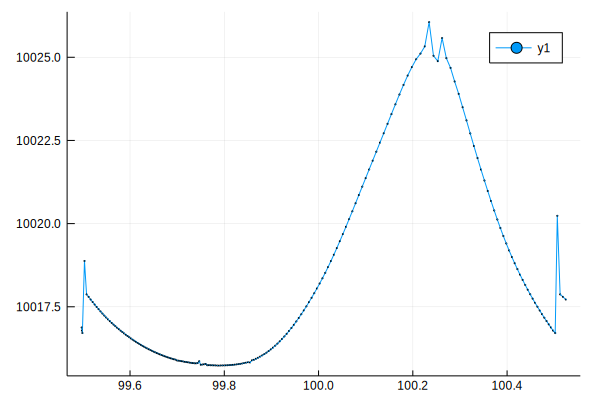

In [75]:
#using Plots
plot(x1,uo1[:,2],marker = 1)

In [29]:
function Source(x::Array{Float64,1},t::Float64, kp::Int, con::Const = con1)::Array{Float64,2}
    I, = size(x)
    src = zeros(Float64,(I,4))
    a = 1.e4
    b = 0.1
    s = 6.e7
    
    ρ0 = con.ρ0
    a0 = con.a0
    
    
    if kp == 5
        for i in 2:I
            dx = x[i] - x[i-1]
            
            x1 = (x[i]+x[i-1])/2
            η = 1-b*sin(2π*(x1-a*t))
            rho_x=-2π*ρ0*b*cos(2π*(x1-a*t))
            sxx_x=2π*s*cos(2π*(x1-a*t))
            s21=a0^2*fηη(η*ρ0,con1)*rho_x-sxx_x
            
            

            x2=x1+sqrt(0.6)*(dx/2)
             η = 1-b*sin(2π*(x2-a*t))
            rho_x=-2π*ρ0*b*cos(2π*(x2-a*t))
            sxx_x=2π*s*cos(2π*(x2-a*t))
            s22=a0^2*fηη(η*ρ0,con1)*rho_x-sxx_x
 

            x3=x1- sqrt(0.6)*(dx/2)
            η = 1-b*sin(2π*(x3-a*t))
            rho_x=-2π*ρ0*b*cos(2π*(x3-a*t))
            sxx_x=2π*s*cos(2π*(x3-a*t))
            s23=a0^2*fηη(η*ρ0,con1)*rho_x-sxx_x
 
            s2=(8/9*s21+s22*5/9+s23*5/9)*dx/2
            s3=s2*a
            
            src[i,1] = 0.0
            src[i,2] = s2
            src[i,3] = s3
            src[i,4] = 0.0
        end
       # src[1,:] = 0.0
        
    end
    return src 
end





Source (generic function with 2 methods)

In [21]:
function TimeSolve(uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1})
#    uo,u,x=initial()
    tt= problem.tt
    
    t=0.0
    it =1
    
   # plt = Plots.plot() 
    while t<tt
# for i in 1:100
        dt=Cfl(uo,x,inter)
        if t+dt>tt
           dt = tt-t
        end
        
        uo,x=R_K3(t,dt,uo,x,inter)
        t += dt
        #if t/(tt/10) > it
        #    it += 1
            println(dt,"  ", t)
         #  plot(x,uo[:,1])
        #end
    end
    
    return uo,x
end

TimeSolve (generic function with 1 method)

In [22]:
function TwoMatter()
    
    nv = 3
    jx = 500
    tt = 2.0e-6
    cfl = 0.5
    lx =5.0e-2
  
    kindProblem=1
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-12
    sxx2=0.0
    
    
    ρ1=8930
    u1=50
    p1=1.e-12
    sxx1=0.0
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con2 = Const(3e8,2785,2.0,2.76e10,5328,1.338)  #copper
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940,1.49)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]
    
    ii = floor(Int,2.5e-2/dx)
    println(ii)
    for i=1:jx+2nv+1
        if i <= ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            inter[i] =2
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
        
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

TwoMatter (generic function with 1 method)

In [23]:
function Space(uo::Array{Float64,2},inter::Array{Int,1},problem::Global=problem)
    kind_split = 1
    nv = problem.nv
    jx = problem.jx
    hL = zeros(Float64,2)
    hr = zeros(Float64,2)
    
    I,J = size(uo)
    uL=zeros(Float64,(I,J))
    uR=zeros(Float64,(I,J))
    f=zeros(Float64,(I,J))
    uuh=zeros(Float64,I)
     if kind_split==1
        for i in 1:J
            uL[:,i],uR[:,i] = WENO3(uo[:,i],inter,i)
        #    uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
        hL,hR,uuh = HLLCEP(uo[:,2],uL,uR,inter)
     #   hL,hR,uuh = HLLCEPNew(uo[:,2],uL,uR,inter)
     end
    ik = floor(Int,jx/2)+nv+1
    for i in 2:I-1
        if inter[i] != inter[i+1]
            ik = i
        end
    end
    
    for i in 2:ik 
        f[i,:]= hL[i,:]-hL[i-1,:]
    end
    
    for i in ik+1:I
        f[i,:]= hR[i,:]-hR[i-1,:]
    end
    return f,uuh
end

Space (generic function with 2 methods)

In [48]:
function EntropyWithSource()
    
    nv = 3
    jx = 200
    tt = 1.e-2
    cfl = 0.5
    lx =1.0
    kindProblem=5
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=8930
    u1=1.e4
    p1=1.e-6
    sxx1=6.e7
    e0 = 1.e-14
    
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
   # global con1 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
    #    global con2 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)#
    global con2 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    global con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    uexact = zeros(Float64,(jx+2nv+1,4))
    
    
    inter  = zeros(Int,jx+2nv+1)
    
    x = [(i+0.5-nv-1)*dx for i=1:jx+2nv+1]

    for i in  nv+1:jx+nv+1
        inter[i] = 1
        u[i,1] = ρ1*(1-0.1sin(2π*(x[i]+x[i-1])/2))
        u[i,2] = u[i,1]*u1
        u[i,3] = u[i,1]*(e0+0.5u1^2)
        u[i,4] = sxx1*sin(π*(x[i]+x[i-1]))
        uo[i,:]=UToUo(u[i,:],con1)
    end
    
    
    for i in 1:nv
        inter[i] = 1
        uo[i,:] = uo[i+jx,:]
        uo[jx+nv+1+i,:] = uo[nv+1+i,:]
        u[i,:]= UoTou(uo[i,:],con1)
        u[jx+nv+1+i,:] = UoTou(uo[jx+nv+1+i,:],con1)
    end
    
    for i in nv+1:jx+nv+1
        uexact[i,1] = ρ1*(1-0.1sin(2π*((x[i]+x[i-1])/2+u1*tt)))
        uexact[i,2] = u1*uexact[i,1]
        uexact[i,3] = 1.1u1^2*ρ1
        uexact[i,4] = sxx1*sin(2π*((x[i]+x[i-1])/2+u1*tt))
    end
        
    
    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter,uexact
end

EntropyWithSource (generic function with 1 method)

In [25]:
function Piston()
    

    nv = 3
    jx = 800
    tt = 1.5e-4
    cfl = 0.5
    lx =1.0
    
    kindProblem=2
    dx=lx/jx


    ρ2=8930
    u2=0.0
    p2=1.e5
    sxx2=0
    
    
    ρ1=8930
    u1=20.0
    p1=1.e5
    sxx1=0.0
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    #state1=copper

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1 
        uo[i,1] = ρ1
        uo[i,2] = u2
        uo[i,3] = p1
        uo[i,4] = sxx1
        u[i,:]=UoTou(uo[i,:],con1)
        inter[i] = 1
    end 
   

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

#PyPlot.plot(x,uo[:,1:4])
#end

Piston (generic function with 1 method)

In [23]:
function Wilkins()
    
    nv = 3
    jx = 800
    tt = 5.e-6
    cfl = 0.5
    lx =5.e-2
    kindProblem=3
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=2785
    u1=800.0
    p1=1.e-6
    sxx1=0.0
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
    global con1 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)  #
    #con2 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    
    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter  = zeros(Int,jx+2nv+1)
    
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]

    for i=1:jx+2nv+1
        inter[i] = 1
        if x[i] < 5.e-3 
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con1)
        end
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

Wilkins (generic function with 1 method)

In [60]:
uo,u,x,inter = TwoMatter()
#plot(x,uo[:,1])
#plot!(x,inter
uo1,x1 = TimeSolve(uo,x,inter)
#uo2,x2 = TimeSolve(uo,x,inter)
#uo


250
7.752056446453582e-9  7.752056446453582e-9
7.7343287988368e-9  1.5486385245290383e-8
7.72413938748288e-9  2.3210524632773262e-8
7.71833862540885e-9  3.092886325818211e-8
7.715050351988731e-9  3.8643913610170845e-8
7.71320385622489e-9  4.6357117466395734e-8
7.7121712719774e-9  5.406928873837313e-8
7.711582837166134e-9  6.178087157553927e-8
7.71122325298735e-9  6.949209482852662e-8
7.71096926825867e-9  7.72030640967853e-8
7.710752827895001e-9  8.49138169246803e-8
7.710539295783203e-9  9.26243562204635e-8
7.710316186625599e-9  1.003346724070891e-7
7.710087721621334e-9  1.0804476012871043e-7
7.70986808637616e-9  1.157546282150866e-7
7.70968008850771e-9  1.234643083035943e-7
7.709538453571405e-9  1.311738467571657e-7
7.70939099818474e-9  1.3888323775535044e-7
7.709296878695757e-9  1.465925346340462e-7
7.70925460095918e-9  1.5430178923500538e-7
7.709254966583706e-9  1.6201104420158908e-7
7.709259853876295e-9  1.697203040554654e-7
7.709251673233498e-9  1.774295557286989e-7
7.7092587394261

7.709277282611954e-9  1.4957163610895317e-6
7.709277246955178e-9  1.503425638336487e-6
7.709277225258968e-9  1.5111349155617458e-6
7.709277212675711e-9  1.5188441927744214e-6
7.709277205215748e-9  1.5265534699796372e-6
7.709277197512112e-9  1.5342627471771493e-6
7.709277165262438e-9  1.5419720243424118e-6
7.709277144860434e-9  1.5496813014872722e-6
7.709277131667996e-9  1.5573905786189401e-6
7.709277123238995e-9  1.5650998557421792e-6
7.709277118653338e-9  1.5728091328608325e-6
7.709277094098154e-9  1.5805184099549307e-6
7.709277071286864e-9  1.5882276870262176e-6
7.709277040528537e-9  1.595936964066746e-6
7.709277012683515e-9  1.6036462410794296e-6
7.709276983272375e-9  1.611355518062702e-6
7.709276954944043e-9  1.619064795017646e-6
7.709276928045468e-9  1.6267740719456914e-6
7.709276898090773e-9  1.6344833488437822e-6
7.709276870378345e-9  1.6421926257141605e-6
7.709276843487838e-9  1.6499019025576484e-6
7.709276814628592e-9  1.657611179372277e-6
7.709276787778966e-9  1.6653204561600

([8930.0 50.0 0.00178544 0.000122715; 8930.0 50.0 0.00178544 0.000122715; … ; 2785.0 1.36165e-12 0.0109717 0.010884; 2785.0 3.16341e-12 1.00003e-12 -5.39762e-5], [-0.0002, -0.0001, 2.0771e-18, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007  …  0.0494, 0.0495, 0.0496, 0.0497, 0.0498, 0.0499, 0.05, 0.0501, 0.0502, 0.0503])

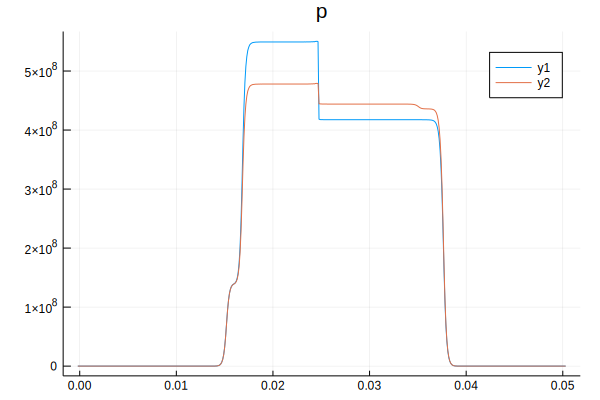

In [77]:
using Plots
plot(x2, uo2[:,3],title = "p" )
plot!(x1,uo1[:,3])

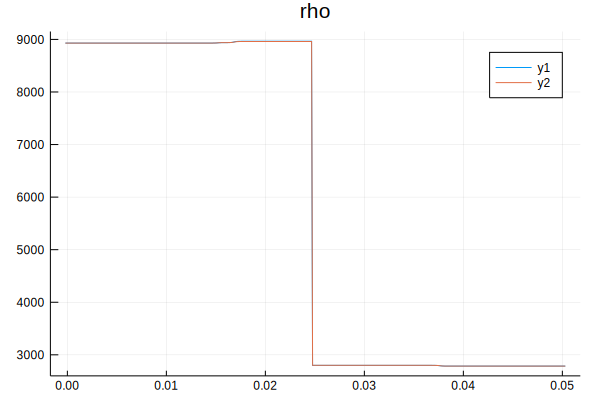

In [74]:
using Plots
plot(x2, uo2[:,1],title = "rho")
plot!(x1,uo1[:,1])

In [21]:
uo,u,x,inter,uexact = EntropyWithSource()
x0 =copy(x)
u0 =copy(uo)
uo1,x1 = TimeSolve(uo,x,inter)
maximum(abs.(uo1[1,:]-uexact[1,:]))

LoadError: UndefVarError: EntropyWithSource not defined

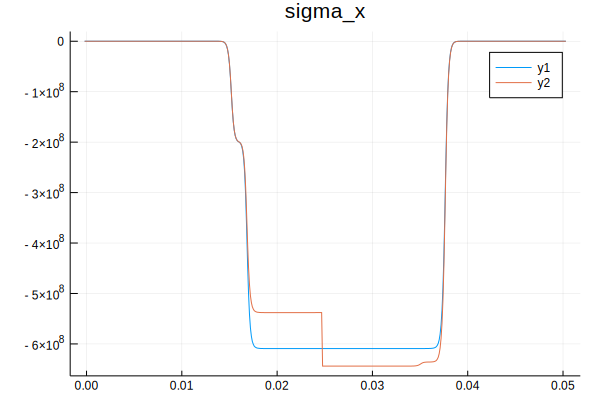

In [70]:
plot(x2, -uo2[:,3]+uo2[:,4],title=("sigma_x"))
plot!(x1,-uo1[:,3]+uo1[:,4])

In [100]:
function Entropy_wave()
    
    nv = 3
    jx = 30
    tt = 1.e-4
    cfl = 0.5
    lx =1.0
    kindProblem=4
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-6
    sxx2=0
    
    
    ρ1=2785
    u1=800.0
    p1=1.e-6
    sxx1=6.e4
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    #global   con = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)  #copper
    
    global con1 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)
        global con2 = Const(3e8,2785,2.0,2.76e10,5328.0,1.338)#
    #con2 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    
    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    uexact = zeros(Float64,(jx+2nv+1,4))
    
    
    inter  = zeros(Int,jx+2nv+1)
    
    x = [(i+0.5-nv-1)*dx for i=1:jx+2nv+1]

    for i in  nv+1:jx+nv+1
        inter[i] = 1
            uo[i,1] = ρ1*(1-0.1sin(2π*(x[i]+x[i-1])/2))
            uo[i,2] = u1
            uo[i,3] = 1.1u1^2*ρ1
            uo[i,4] = sxx1*sin(π*(x[i]+x[i-1]))
            u[i,:]=UoTou(uo[i,:],con1)
    end
    
    
    for i in 1:nv
        inter[i] = 1
        uo[i,:] = uo[i+jx,:]
        uo[jx+nv+1+i,:] = uo[nv+1+i,:]
        u[i,:]= UoTou(uo[i,:],con1)
        u[jx+nv+1+i,:] = UoTou(uo[jx+nv+1+i,:],con1)
    end
    
    for i in nv+1:jx+nv+1
        uexact[i,1] = ρ1*(1-0.1sin(2π*((x[i]+x[i-1])/2+u1*tt)))
        uexact[i,2] = u1
        uexact[i,3] = 1.1u1^2*ρ1
        uexact[i,4] = sxx1*sin(2π*((x[i]+x[i-1])/2+u1*tt))
    end
        
    
    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter,uexact
end

Entropy_wave (generic function with 1 method)

In [103]:
uo,u,x,inter,uexact = Entropy_wave()
x0 =copy(x)
u0 =copy(uo)
uo1,x1 = TimeSolve(uo,x,inter)
maximum(abs.(uo1[1,:]-uexact[1,:]))

2.5413701430890847e-6  2.5413701430890847e-6
2.5413701654753308e-6  5.082740308564415e-6
2.541370164052645e-6  7.62411047261706e-6
2.541370142612816e-6  1.0165480615229877e-5
2.5413701029301206e-6  1.2706850718159998e-5
2.5413700468611423e-6  1.5248220765021141e-5
2.5413699767878294e-6  1.778959074180897e-5
2.5413698937172797e-6  2.033096063552625e-5
2.5413697987050146e-6  2.2872330434231268e-5
2.541369692848715e-6  2.5413700127079984e-5
2.541369577380898e-6  2.795506970446088e-5
2.541369453696313e-6  3.0496439158157194e-5
2.5413693231382935e-6  3.303780848129549e-5
2.5413691873070156e-6  3.5579177668602506e-5
2.54136904808278e-6  3.8120546716685284e-5
2.5413689075203267e-6  4.066191562420561e-5
2.5413687677902976e-6  4.320328439199591e-5
2.541368630827776e-6  4.574465302282368e-5
2.5413684981093445e-6  4.828602152093303e-5
2.541368370497018e-6  5.082738989143005e-5
2.541368248088539e-6  5.3368758139518586e-5
2.5413681323914215e-6  5.591012627191001e-5
2.5413680243516673e-6  5.84514942

1.9605983077864518e9

In [105]:
#using Plots
I,J = size(uo1)
uerr=zeros(Float64,(I,J))
uerr = (uo1-u0)./u0
maximum(uerr[4:I-6,1])
#maximum(abs.(x0-x1).-0.08)
#plot(x1[4:I-6],uerr[4:I-6,1],marker=2)
#x0

8.128123765326218e-7

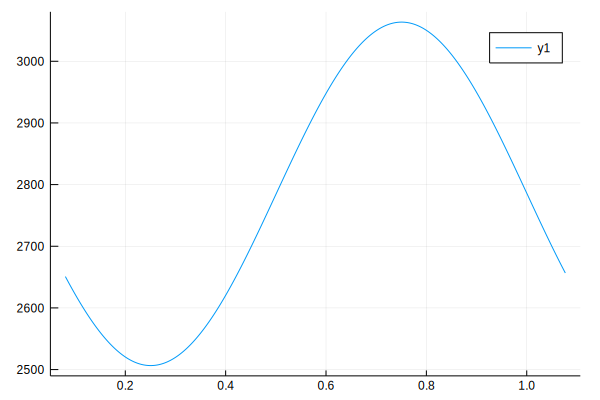

In [102]:
#plot(x1[4:I-6],uo1[4:I-6,1])
plot(x1[4:I-6],uexact[4:I-6,1])
#plot!(x2[4:I-6],uo2[4:I-6,1])
#plot!(x1[4:I-6],uo1[4:I-6,1])

In [ ]:
800 0.051253201119014026

In [27]:
uo,u,x,inter = Piston()
uo1,x1 = TimeSolve(uo,x,inter)
#x1[1] = x1[2]-0.001
plot(x1,u)

1.3252193095233308e-7  1.3252193095233308e-7
1.3249736815886636e-7  2.6501929911119946e-7
1.3243774496685598e-7  3.9745704407805545e-7
1.3236001856187985e-7  5.298170626399353e-7
1.3227170459893043e-7  6.620887672388658e-7
1.3218610255801537e-7  7.942748697968811e-7
1.3211313318132434e-7  9.263880029782055e-7
1.320559711996832e-7  1.0584439741778887e-6
1.3201333808756962e-7  1.1904573122654585e-6
1.3198173962979166e-7  1.32243905189525e-6
1.3195736838878876e-7  1.4543964202840387e-6
1.319372783404079e-7  1.5863336986244467e-6
1.3191958839363907e-7  1.7182532870180858e-6
1.3190386430442245e-7  1.8501571513225082e-6
1.3189145928313108e-7  1.9820486106056393e-6
1.3188328992016276e-7  2.113931900525802e-6
1.3187974887580576e-7  2.2458116494016075e-6
1.318799446061319e-7  2.3776915940077393e-6
1.318808003222947e-7  2.5095723943300338e-6
1.3188154856102628e-7  2.64145394289106e-6
1.3188258203662632e-7  2.7733365249276863e-6
1.3188212961523172e-7  2.905218654542918e-6
1.3188089118036914e-7  3

1.3187920441569583e-7  2.55884353316507e-5
1.318792042211867e-7  2.5720314535871884e-5
1.3187920403368744e-7  2.585219373990557e-5
1.3187920385244902e-7  2.598407294375802e-5
1.318792036765945e-7  2.6115952147434613e-5
1.3187920350517395e-7  2.6247831350939788e-5
1.3187920333722058e-7  2.637971055427701e-5
1.3187920317180465e-7  2.6511589757448814e-5
1.318792030080839e-7  2.66434689604569e-5
1.3187920284534823e-7  2.6775348163302246e-5
1.3187920268305664e-7  2.69072273659853e-5
1.3187920252086582e-7  2.7039106568506166e-5
1.3187920235864829e-7  2.7170985770864814e-5
1.3187920219650103e-7  2.7302864973061317e-5
1.3187920203474503e-7  2.7434744175096063e-5
1.3187920187391505e-7  2.7566623376969978e-5
1.318792017147395e-7  2.769850257868472e-5
1.3187920155810834e-7  2.7830381780242826e-5
1.3187920140502916e-7  2.7962260981647854e-5
1.3187920125657393e-7  2.8094140182904427e-5
1.318792011138209e-7  2.822601938401825e-5
1.3187920097779628e-7  2.8357898584996044e-5
1.3187920084942182e-7  2.8

1.318791911831816e-7  5.130487863966554e-5
1.3187919115077225e-7  5.143675783081631e-5
1.318791911183493e-7  5.156863702193466e-5
1.318791910858578e-7  5.1700516213020514e-5
1.3187919105326396e-7  5.1832395404073776e-5
1.3187919102055647e-7  5.196427459509433e-5
1.3187919098774705e-7  5.209615378608208e-5
1.3187919095486947e-7  5.222803297703695e-5
1.318791909219778e-7  5.235991216795893e-5
1.3187919088914286e-7  5.249179135884807e-5
1.3187919085644855e-7  5.2623670549704515e-5
1.3187919082398718e-7  5.27555497405285e-5
1.3187919079185353e-7  5.288742893132036e-5
1.3187919076014035e-7  5.30193081220805e-5
1.3187919072893293e-7  5.315118731280943e-5
1.3187919069830443e-7  5.328306650350773e-5
1.3187919066831174e-7  5.341494569417604e-5
1.3187919063899312e-7  5.3546824884815034e-5
1.318791906103656e-7  5.36787040754254e-5
1.3187919058242503e-7  5.381058326600783e-5
1.318791905551461e-7  5.394246245656297e-5
1.318791905284842e-7  5.4074341647091454e-5
1.3187919050237809e-7  5.420622083759

1.3187918784432824e-7  7.794447483692066e-5
1.3187918783769844e-7  7.807635402475836e-5
1.318791878311213e-7  7.820823321258948e-5
1.318791878245785e-7  7.834011240041406e-5
1.3187918781805235e-7  7.847199158823211e-5
1.3187918781152705e-7  7.860387077604364e-5
1.3187918780498907e-7  7.873574996384863e-5
1.3187918779842803e-7  7.886762915164706e-5
1.3187918779183727e-7  7.89995083394389e-5
1.318791877852139e-7  7.913138752722411e-5
1.3187918777855894e-7  7.926326671500267e-5
1.3187918777187717e-7  7.939514590277454e-5
1.3187918776517656e-7  7.952702509053973e-5
1.3187918775846803e-7  7.96589042782982e-5
1.3187918775176427e-7  7.979078346604996e-5
1.3187918774507938e-7  7.992266265379505e-5
1.318791877384276e-7  8.005454184153348e-5
1.3187918773182265e-7  8.01864210292653e-5
1.3187918772527694e-7  8.031830021699059e-5
1.3187918771880068e-7  8.04501794047094e-5
1.3187918771240164e-7  8.058205859242179e-5
1.3187918770608444e-7  8.071393778012787e-5
1.3187918769985073e-7  8.084581696782771

1.318791870342998e-7  0.00010339715799816198
1.3187918703191112e-7  0.0001035290371851939
1.3187918702953459e-7  0.00010366091637222343
1.318791870271711e-7  0.0001037927955592506
1.3187918702482127e-7  0.00010392467474627542
1.3187918702248545e-7  0.00010405655393329791
1.318791870201635e-7  0.00010418843312031807
1.318791870178552e-7  0.00010432031230733592
1.3187918701555976e-7  0.00010445219149435149
1.3187918701327664e-7  0.00010458407068136476
1.3187918701100442e-7  0.00010471594986837577
1.318791870087424e-7  0.00010484782905538452
1.318791870064893e-7  0.000104979708242391
1.3187918700424422e-7  0.00010511158742939525
1.318791870020062e-7  0.00010524346661639726
1.3187918699977456e-7  0.00010537534580339704
1.3187918699754887e-7  0.00010550722499039459
1.3187918699532907e-7  0.00010563910417738992
1.3187918699311537e-7  0.00010577098336438304
1.318791869909084e-7  0.00010590286255137396
1.3187918698870863e-7  0.00010603474173836266
1.318791869865173e-7  0.00010616662092534918
1

1.3187918673309426e-7  0.00012726729082082863
1.318791867318545e-7  0.00012739917000756048
1.3187918673062047e-7  0.0001275310491942911
1.3187918672939254e-7  0.00012766292838102048
1.3187918672817104e-7  0.00012779480756774865
1.3187918672695602e-7  0.0001279266867544756
1.3187918672574797e-7  0.00012805856594120136
1.318791867245468e-7  0.0001281904451279259
1.3187918672335274e-7  0.00012832232431464924
1.3187918672216615e-7  0.00012845420350137142
1.3187918672098732e-7  0.0001285860826880924
1.318791867198165e-7  0.00012871796187481223
1.3187918671865372e-7  0.00012884984106153089
1.3187918671749956e-7  0.00012898172024824838
1.3187918671635416e-7  0.00012911359943496473
1.3187918671521794e-7  0.00012924547862167994
1.318791867140912e-7  0.00012937735780839404
1.3187918671297429e-7  0.000129509236995107
1.3187918671186745e-7  0.0001296411161818189
1.3187918671077134e-7  0.00012977299536852965
1.3187918670968613e-7  0.00012990487455523934
1.3187918670861215e-7  0.00013003675374194794

LoadError: UndefVarError: plot not defined

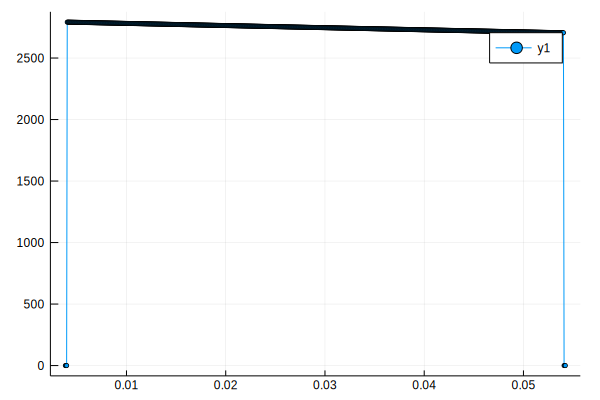

In [53]:
using Plots
plot(x1,uexact[:,1],marker=2)

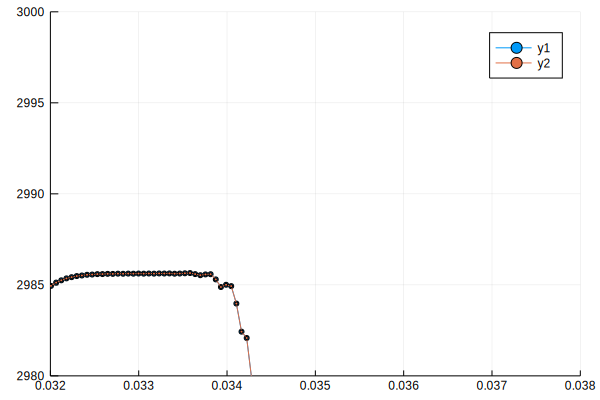

In [363]:
plot(x3,uo3[:,1],marker = 3)
plot!(x2,uo2[:,1],marker = 2,xlims = (0.032,0.038),ylims = (2980,3000))

In [326]:
uo,u,x,inter = Piston()
uo2,x2 = TimeSolve(uo,x,inter)

1.3252193095233308e-7  1.3252193095233308e-7
1.3249736815886636e-7  2.6501929911119946e-7
1.3243774496685598e-7  3.9745704407805545e-7
1.3236001856187985e-7  5.298170626399353e-7
1.3227170459893043e-7  6.620887672388658e-7
1.3218610255801537e-7  7.942748697968811e-7
1.3211313318132434e-7  9.263880029782055e-7
1.320559711996832e-7  1.0584439741778887e-6
1.3201333808756962e-7  1.1904573122654585e-6
1.3198173962979166e-7  1.32243905189525e-6
1.3195736838878876e-7  1.4543964202840387e-6
1.319372783404079e-7  1.5863336986244467e-6
1.3191958839363907e-7  1.7182532870180858e-6
1.3190386430442245e-7  1.8501571513225082e-6
1.3189145928313108e-7  1.9820486106056393e-6
1.3188328992016276e-7  2.113931900525802e-6
1.3187974887580576e-7  2.2458116494016075e-6
1.318799446061319e-7  2.3776915940077393e-6
1.318808003222947e-7  2.5095723943300338e-6
1.3188154856102628e-7  2.64145394289106e-6
1.3188258203662632e-7  2.7733365249276863e-6
1.3188212961523172e-7  2.905218654542918e-6
1.3188089118036914e-7  3

1.3187920574542408e-7  2.4797160101966637e-5
1.3187920550516176e-7  2.49290393074718e-5
1.318792052717682e-7  2.5060918512743566e-5
1.318792050458487e-7  2.5192797717789417e-5
1.3187920482780208e-7  2.532467692261722e-5
1.318792046177846e-7  2.5456556127235003e-5
1.3187920441569583e-7  2.55884353316507e-5
1.318792042211867e-7  2.5720314535871884e-5
1.3187920403368744e-7  2.585219373990557e-5
1.3187920385244902e-7  2.598407294375802e-5
1.318792036765945e-7  2.6115952147434613e-5
1.3187920350517395e-7  2.6247831350939788e-5
1.3187920333722058e-7  2.637971055427701e-5
1.3187920317180465e-7  2.6511589757448814e-5
1.318792030080839e-7  2.66434689604569e-5
1.3187920284534823e-7  2.6775348163302246e-5
1.3187920268305664e-7  2.69072273659853e-5
1.3187920252086582e-7  2.7039106568506166e-5
1.3187920235864829e-7  2.7170985770864814e-5
1.3187920219650103e-7  2.7302864973061317e-5
1.3187920203474503e-7  2.7434744175096063e-5
1.3187920187391505e-7  2.7566623376969978e-5
1.318792017147395e-7  2.7698

1.3187919148865343e-7  5.011796591782349e-5
1.3187919145243647e-7  5.024984510927593e-5
1.3187919141695103e-7  5.038172430069288e-5
1.3187919138215047e-7  5.051360349207503e-5
1.3187919134796867e-7  5.0645482683422996e-5
1.3187919131432378e-7  5.077736187473732e-5
1.3187919128112255e-7  5.090924106601844e-5
1.3187919124826506e-7  5.1041120257266704e-5
1.3187919121565024e-7  5.117299944848235e-5
1.318791911831816e-7  5.130487863966554e-5
1.3187919115077225e-7  5.143675783081631e-5
1.318791911183493e-7  5.156863702193466e-5
1.318791910858578e-7  5.1700516213020514e-5
1.3187919105326396e-7  5.1832395404073776e-5
1.3187919102055647e-7  5.196427459509433e-5
1.3187919098774705e-7  5.209615378608208e-5
1.3187919095486947e-7  5.222803297703695e-5
1.318791909219778e-7  5.235991216795893e-5
1.3187919088914286e-7  5.249179135884807e-5
1.3187919085644855e-7  5.2623670549704515e-5
1.3187919082398718e-7  5.27555497405285e-5
1.3187919079185353e-7  5.288742893132036e-5
1.3187919076014035e-7  5.3019308

1.3187918794828645e-7  7.60981662064498e-5
1.318791879402216e-7  7.623004539439002e-5
1.31879187932212e-7  7.636192458232224e-5
1.3187918792427293e-7  7.649380377024651e-5
1.3187918791641924e-7  7.662568295816293e-5
1.3187918790866513e-7  7.675756214607159e-5
1.3187918790102304e-7  7.688944133397261e-5
1.3187918789350263e-7  7.702132052186611e-5
1.3187918788611029e-7  7.715319970975222e-5
1.3187918787884878e-7  7.728507889763107e-5
1.3187918787171697e-7  7.741695808550278e-5
1.3187918786470965e-7  7.75488372733675e-5
1.3187918785781777e-7  7.768071646122531e-5
1.3187918785102904e-7  7.781259564907633e-5
1.3187918784432824e-7  7.794447483692066e-5
1.3187918783769844e-7  7.807635402475836e-5
1.318791878311213e-7  7.820823321258948e-5
1.318791878245785e-7  7.834011240041406e-5
1.3187918781805235e-7  7.847199158823211e-5
1.3187918781152705e-7  7.860387077604364e-5
1.3187918780498907e-7  7.873574996384863e-5
1.3187918779842803e-7  7.886762915164706e-5
1.3187918779183727e-7  7.89995083394389

1.3187918707606335e-7  0.0001011552118182478
1.3187918707352736e-7  0.00010128709100532133
1.318791870710092e-7  0.00010141897019239234
1.318791870685068e-7  0.00010155084937946084
1.318791870660179e-7  0.00010168272856652686
1.318791870635404e-7  0.0001018146077535904
1.318791870610721e-7  0.00010194648694065147
1.3187918705861135e-7  0.00010207836612771008
1.3187918705615654e-7  0.00010221024531476623
1.3187918705370687e-7  0.00010234212450181994
1.318791870512615e-7  0.0001024740036888712
1.318791870488205e-7  0.00010260588287592002
1.3187918704638395e-7  0.0001027377620629664
1.318791870439525e-7  0.00010286964125001036
1.3187918704152712e-7  0.00010300152043705189
1.318791870391091e-7  0.000103133399624091
1.3187918703669953e-7  0.00010326527881112769
1.318791870342998e-7  0.00010339715799816198
1.3187918703191112e-7  0.0001035290371851939
1.3187918702953459e-7  0.00010366091637222343
1.318791870271711e-7  0.0001037927955592506
1.3187918702482127e-7  0.00010392467474627542
1.31879

1.318791867521026e-7  0.00012528910301969965
1.3187918675082679e-7  0.00012542098220645048
1.318791867495507e-7  0.00012555286139320003
1.318791867482745e-7  0.00012568474057994832
1.3187918674699843e-7  0.00012581661976669532
1.3187918674572278e-7  0.00012594849895344106
1.3187918674444804e-7  0.00012608037814018552
1.318791867431747e-7  0.0001262122573269287
1.3187918674190308e-7  0.00012634413651367062
1.3187918674063378e-7  0.00012647601570041125
1.3187918673936736e-7  0.00012660789488715062
1.3187918673810417e-7  0.00012673977407388874
1.318791867368449e-7  0.00012687165326062558
1.3187918673558983e-7  0.00012700353244736117
1.318791867343395e-7  0.00012713541163409552
1.3187918673309426e-7  0.00012726729082082863
1.318791867318545e-7  0.00012739917000756048
1.3187918673062047e-7  0.0001275310491942911
1.3187918672939254e-7  0.00012766292838102048
1.3187918672817104e-7  0.00012779480756774865
1.3187918672695602e-7  0.0001279266867544756
1.3187918672574797e-7  0.0001280585659412013

([8973.45 20.0 6.83257e8 -5.84339e7; 8973.45 20.0 6.83257e8 -5.84339e7; … ; 8930.0 -5.19312e-14 100000.0 -0.0123127; 8930.0 -8.18449e-14 100000.0 0.0123116], [-0.000746479, 0.0005, 0.00174648, 0.00299043, 0.00423438, 0.00547831, 0.00672226, 0.0079662, 0.00921015, 0.0104541  …  0.9925, 0.99375, 0.995, 0.99625, 0.9975, 0.99875, 1.0, 1.00125, 1.0025, 1.00375])

In [328]:
uo2

807×4 Array{Float64,2}:
 8973.45  20.0               6.83257e8  -5.84339e7
 8973.45  20.0               6.83257e8  -5.84339e7
 8973.45  20.0               6.83257e8  -5.84339e7
 8973.45  20.0               6.83257e8  -5.84339e7
 8973.44  20.0               6.8207e8   -5.96211e7
 8973.52  20.0               6.83123e8  -5.85682e7
 8973.45  20.0               6.8197e8   -5.97212e7
 8973.5   20.0               6.82665e8  -5.90261e7
 8973.45  20.0               6.81863e8  -5.98282e7
 8973.48  20.0               6.82274e8  -5.94167e7
 8973.45  20.0               6.81809e8  -5.98823e7
 8973.46  20.0               6.81999e8  -5.96919e7
 8973.45  20.0               6.818e8    -5.98915e7
    ⋮                                             
 8930.0    2.39121e-13  100000.0         0.0123093
 8930.0    2.07594e-13  100000.0        -0.012315 
 8930.0    1.87083e-13  100000.0         0.0123104
 8930.0    1.54432e-13  100000.0         0.0123107
 8930.0    1.11609e-13  100000.0        -0.024626 
 8930.0

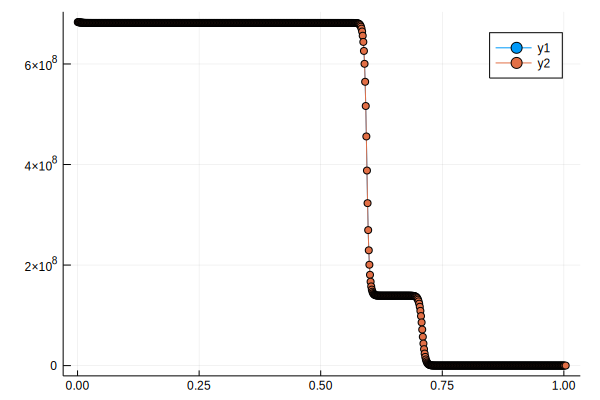

In [316]:
plot(x1,uo1[:,3],marker=1)#xlims = (0.02,0.03), ylims = (4e8,4.2e8))
plot!(x2,uo2[:,3],marker=4)

250
7.752056446453582e-9  7.752056446453582e-9
7.734597057403835e-9  1.5486653503857417e-8
7.724525945701223e-9  2.321117944955864e-8
7.719033591586771e-9  3.093021304114541e-8
7.716093963423798e-9  3.864630700456921e-8
7.714569694005609e-9  4.636087669857482e-8
7.713808669324152e-9  5.4074685367898975e-8
7.713437119529542e-9  6.178812248742851e-8
7.71324437664168e-9  6.95013668640702e-8
7.71311499628102e-9  7.721448186035121e-8
7.71298907881725e-9  8.492747093916845e-8
7.712839400085955e-9  9.26403103392544e-8
7.712659464831941e-9  1.0035296980408634e-7
7.712457344748723e-9  1.0806542714883507e-7
7.712252409913436e-9  1.157776795587485e-7
7.712070624235784e-9  1.2348975018298429e-7
7.711936489636813e-9  1.312016866726211e-7
7.711827742201542e-9  1.3891351441482264e-7
7.711748527750863e-9  1.466252629425735e-7
7.711718285971109e-9  1.543369812285446e-7
7.711725854690686e-9  1.620487070832353e-7
7.71170532230364e-9  1.6976041240553893e-7
7.711705410748197e-9  1.7747211781628712e-7
7.711

7.711784877918085e-9  1.5810166857018272e-6
7.711784902582196e-9  1.5887284706044093e-6
7.711784837946218e-9  1.5964402554423556e-6
7.71178486760641e-9  1.604152040309962e-6
7.711784845947586e-9  1.6118638251559097e-6
7.711784865665105e-9  1.6195756100215747e-6
7.711784802561625e-9  1.6272873948241365e-6
7.7117848165897e-9  1.6349991796407261e-6
7.711784824572241e-9  1.6427109644652984e-6
7.711784831836138e-9  1.6504227492971347e-6
7.711784785592276e-9  1.658134534082727e-6
7.711784776117584e-9  1.6658463188588445e-6
7.711784813813029e-9  1.6735581036726576e-6
7.711784809445224e-9  1.6812698884821027e-6
7.711784781670936e-9  1.6889816732637736e-6
7.711784735829966e-9  1.6966934579996036e-6
7.711784776267661e-9  1.7044052427758713e-6
7.711784787521212e-9  1.7121170275633924e-6
7.711784805505056e-9  1.7198288123688974e-6
7.711784710354155e-9  1.7275405970792515e-6
7.711784730035632e-9  1.7352523818092871e-6
7.71178477456895e-9  1.7429641665838561e-6
7.711784790425372e-9  1.75067595137428

([8930.0 50.0 0.00163146 3.03436e-5; 8930.0 50.0 0.00163146 3.03436e-5; … ; 2785.0 1.36163e-12 0.0109717 0.010884; 2785.0 3.16339e-12 1.00003e-12 -5.39762e-5], [-0.0002, -0.0001, -4.85646e-18, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007  …  0.0494, 0.0495, 0.0496, 0.0497, 0.0498, 0.0499, 0.05, 0.0501, 0.0502, 0.0503])

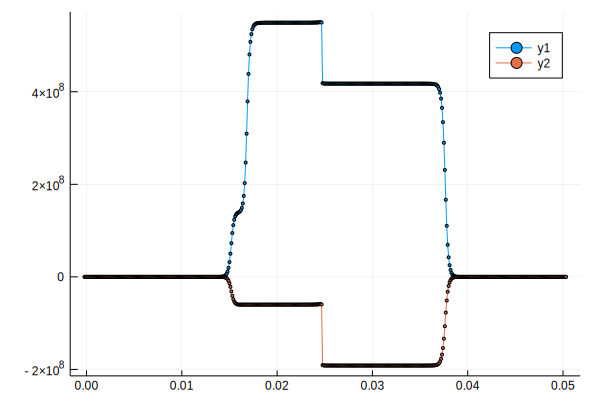

In [32]:
#plot(x1,uo1[:,3:4],marker=2)#xlims = (0.02,0.03), ylims = (4e8,4.2e8))
plot(x2,uo2[:,3:4],marker=2)

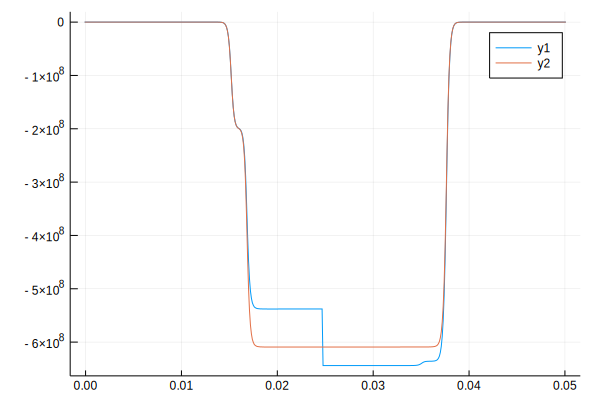

In [255]:
plot(x1,-uo1[:,3]+uo1[:,4])
plot!(x2,-uo2[:,3]+uo2[:,4])

In [111]:
uo,u,x,inter = TwoMatter1()
I,J =size(uo)
uL = zeros(Float64,(I,J))
uR = zeros(Float64,(I,J))
for i in 1:4
    uL[:,i],uR[:,i] = WENO3(uo[:,i])
end

@time HLLCEP(uo[:,2],uL,uR,inter)
@time HLLCEPNew(uo[:,2],uL,uR,inter)
@time HLLCEPNew1(uo[:,2],uL,uR,inter)

250
  0.000174 seconds (4.57 k allocations: 190.844 KiB)
  0.001129 seconds (56.38 k allocations: 1000.328 KiB)
  0.000857 seconds (44.31 k allocations: 1.026 MiB)


([0.0 NaN NaN NaN; 0.0 1.0e-12 5.0e-11 -3.0e12; … ; 0.0 NaN NaN NaN; 0.0 NaN NaN NaN], [NaN, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, NaN, NaN])

In [181]:
using Pkg

In [1]:
#ue = zeros(Float64,4)
ue[1:4] = [1, 2, 3 ,4]

LoadError: UndefVarError: ue not defined

In [86]:
function test(c)
    if c^2 < 2
        return c
    else
        for i in 1:100000
            c += sqrt(0.01*c)*exp(0.1*c)-sin(c)
        end
    end
    return c
end
function test1(c)
    if c^2 < 2
        return c
    end
end
@time test(1)
@time test(0.2)
@time test(2)
@time test(3)
@time test(0.5)
@time test1(1)
@time test1(0.2)
@time test1(2)
@time test1(3)
@time test1(0.5)

  0.014499 seconds (34.22 k allocations: 1.789 MiB)
  0.008761 seconds (21.92 k allocations: 1.171 MiB)
  0.002532 seconds (5 allocations: 176 bytes)
  0.003133 seconds (5 allocations: 176 bytes)
  0.000002 seconds (5 allocations: 176 bytes)
  0.004922 seconds (1.96 k allocations: 107.191 KiB)
  0.005580 seconds (8.06 k allocations: 453.139 KiB)
  0.000003 seconds (4 allocations: 160 bytes)
  0.000002 seconds (4 allocations: 160 bytes)
  0.000002 seconds (5 allocations: 176 bytes)


0.5

In [130]:
uo,u,x,inter = TwoMatter1()
I,J =size(uo)
uL = zeros(Float64,(I,J))
uR = zeros(Float64,(I,J))
for i in 1:4
    uL[:,i],uR[:,i] = WENO3(uo[:,i])
end
HLLCEPNew(uo[:,2],uL,uR,inter)

250


([0.0 NaN NaN NaN; 0.0 1.0e-12 5.0e-11 -3.0e12; … ; 0.0 NaN NaN NaN; 0.0 NaN NaN NaN], [NaN, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, NaN, NaN])